In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.utils import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

join,"Join two or more pathname components, inserting '/' as needed"
abspath,Return an absolute path.
dirname,Returns the directory component of a pathname
isfile,Test whether a path is a regular file
isdir,Return true if the pathname refers to an existing directory.
basename,Returns the final component of a pathname
splitext,Split the extension from a pathname
expanduser,Expand ~ and ~user constructions
isabs,Test whether a path is absolute
sys,This module provides access to some objects used or maintained by the
os,OS routines for NT or Posix depending on what system we're on


In [6]:
printhtml('<h3>Defining notebook variables</h3>')

# matplotlib stuff. Note that rcParams need to be input from the second cell on
# (https://github.com/jupyter/notebook/issues/3385#issuecomment-376010658)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# for font size details, see https://stackoverflow.com/a/39566040
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

# pandas settings. Some are set in `share`, display max_rows is explicitly set here
pd.set_option('display.max_rows', 25)

TRAINSET = 'allset_train.hdf'
TRAINSET_U = 'uniform_train.hdf'
TESTSETNAME1 = 'allset_test.hdf'
TESTSETNAME2 = 'allset_unlabelled_annotation2.hdf'
TESTSETNAME_12 = 'allset_test_AND_allset_unlabelled_annotation2.hdf'
TESTSETNAME_UNLABELLED = 'allset_unlabelled.hdf'
TESTSETNAME_U = 'uniform_test.hdf'

SAVE_FIGURES = False  # set to False to disable figures in the function below

# columns to display for an Evaluation dataframe:
EVALDF_DISPLAYCOLUMNS = ['clf', 'feats', 'n_estimators', 'max_samples', 'random_state', 'average_precision_score',
                         'best_th_pr_curve', 'roc_auc_score', 'log_loss', 'relative_filepath',
                         # these are useless to show. The first is an experimental metric,
                         # the other three are parameters always equal for all models:
                         # 'best_th_roc_curve', 'behaviour', 'contamination',  'tr_set'
                        ]


from sod.core.paths import DATASETS_DIR

def savefig(fig, name):
    '''Save a figure for the paper in a dedicated folder'''
    if not SAVE_FIGURES:
        print('(SAVE_FIGURES=False)')
        return
    root = os.path.expanduser('~')
    outpath = abspath(join(root, 'Nextcloud', 'rizac', 'outliers_paper', 'paper_figures'))
    assert isdir(outpath)
    outpath = join(outpath, name + '.png')
    printhtml('Saving figure to "~/%s"' % os.path.relpath(abspath(outpath), root))
    fig.savefig(outpath, dpi=plt.rcParams['figure.dpi'], format='png')
    # join(dirname(dirname(dirname(os.getcwd())))

import yaml
from stream2segment.process.db import get_session, Segment, Station, Event, loads_inv, Base 

def get_db_session(dataset_id):
    '''returns an SQLAlchemy session from the given dataset_id (1: europe, 2: me, 3: chile)'''
    keys = [None, 'dbpath_eu_new', 'dbpath_me', 'dbpath_chile']
    with open(join(os.getcwd(), 'jnconfig.yaml')) as _:
        dburl = yaml.safe_load(_)[keys[dataset_id]]
    # Use stream2segment API, which also loads the Segment obspy capabilities (Segmetn)
    return get_session(dburl)
    # Or load session with the SQLAlchemy lower level API:
#     from sqlalchemy import create_engine
#     engine = create_engine(dburl, connect_args={'connect_timeout': 10})  # 
#     Base.metadata.create_all(engine)  # @UndefinedVariable
#     from sqlalchemy.orm.session import sessionmaker
#     return sessionmaker(bind=engine)()

from obspy.signal.spectral_estimation import PPSD

def ppsd(raw_trace, inventory, periods=None):
    '''Returns the arrays
        periods, amplitudes_db
    Where amplitudes are the computed PSD (power spectral density)
    if the argument `periods` is not None but an array or scalar (in seconds), returns:
        periods, amplitudes_db_interpolated_on_periods
    '''
    try:
        # ppsd_ = psd(raw_trace, inventory)
        dt = raw_trace.stats.endtime - raw_trace.stats.starttime  # total_seconds
        ppsd_ = PPSD(raw_trace.stats, metadata=inventory, ppsd_length=int(dt))
        ppsd_.add(raw_trace)
    except Exception as esc:
        raise ValueError('%s error when computing PSD: %s' %
                         (esc.__class__.__name__, str(esc)))
    # check first if we can interpolate ESPECIALLY TO SUPPRESS A WEIRD
    # PRINTOUT (numpy?): something like '5064 5062' which happens
    # on IndexError (len(ppsd_.psd_values)=0)
    if not len(ppsd_.psd_values):
        raise ValueError('Expected 1 psd array, no psd computed')
    x, y = ppsd_.period_bin_centers, ppsd_.psd_values[0]
    if periods is None:
        return x, y
    periods = np.asarray(periods)
    newy = np.interp(np.log10(periods), np.log10(x), y)
    if np.ndim(newy) > 0:
        newy[periods < x[0]] = np.nan
        newy[periods > x[-1]] = np.nan
    return x, newy

print('done')

Defining notebook variables

done


In [3]:
printhtml('<h3>Some stats on input datasets used</h3>')

for n in ['me_at_rz_minus_vm258.hdf', 's2s_2019_03_at_rs5.hdf', 'sod_chile_at_rs5.hdf', 'sod_dist_2_20_at_rs5.hdf']:
    # store.close()
    store = pd.HDFStore(join(DATASETS_DIR, n))
    try:
        nrows = store.get_storer(list(store.keys())[0]).nrows
        printhtml(f'<h4>Dataset "{n}": {nrows:,d} segments</h4>')
        print()
    finally:
        store.close()


Some stats on input datasets used

Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/me_at_rz_minus_vm258.hdf in read-only mode


Dataset "me_at_rz_minus_vm258.hdf": 7,037,596 segments


Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/s2s_2019_03_at_rs5.hdf in read-only mode


Dataset "s2s_2019_03_at_rs5.hdf": 12,925,792 segments


Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/sod_chile_at_rs5.hdf in read-only mode


Dataset "sod_chile_at_rs5.hdf": 159,300 segments


Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/sod_dist_2_20_at_rs5.hdf in read-only mode


Dataset "sod_dist_2_20_at_rs5.hdf": 36,972 segments

In [19]:
def magdist(dataframe, ceil=None):
    colx, coly = 'distance_km', 'magnitude'
    # CEIL = 5000
    # printhtml(f'<h4>Training segment distribution (signal parts ognly) with ceiling at {CEIL} segments per cell</h4>')
    dfr = heatmap_df(dataframe, colx, coly,
                         np.arange(0, 12000, 1000), np.arange(0.5, 9.5, 0.5))

    if ceil:
        dfr[dfr > ceil] = ceil
    print(f'{dfr.sum().sum():,d} instances')
    display(dfr.iloc[::-1])

    # Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
    # Cols = ['A', 'B', 'C', 'D']
    # df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 12

    plt.pcolor(dfr, cmap='hot_r')
    plt.yticks(np.arange(0.5, len(dfr.index), 1), dfr.index)
    plt.xticks(np.arange(0.5, len(dfr.columns), 1), dfr.columns)
    plt.ylabel(coly)
    plt.xlabel(colx)
    plt.xticks(rotation=80)
    # plt.grid()
    plt.show()
    return dfr

Train set distance / magnitude heatmap

Trainingset Segment distribution (signal parts ognly)

405,835 total instances (including noise only windows)
272,760 instances


distance_km,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 6000]","(6000, 7000]","(7000, 8000]","(8000, 9000]","(9000, 10000]","(10000, 11000]"
magnitude,,,,,,,,,,,
"(8.5, 9.0]",1,4,17,17,27,45,44,30,77,220,40
"(8.0, 8.5]",106,10,21,26,34,45,32,49,68,184,110
"(7.5, 8.0]",132,67,339,347,580,778,690,741,896,1217,809
"(7.0, 7.5]",113,261,777,929,1363,1544,1395,1437,1855,3094,2039
"(6.5, 7.0]",931,1107,2003,2342,3594,4005,4283,4751,5015,4997,4945
"(6.0, 6.5]",2886,2569,4882,5012,4998,4942,4953,4983,5011,5012,5011
"(5.5, 6.0]",3294,880,5031,5010,4999,4999,4984,4993,5001,4999,4991
"(5.0, 5.5]",5008,0,4986,5000,5002,4990,4988,5000,5005,4998,4997
"(4.5, 5.0]",4994,0,2245,2036,2527,2949,3882,3823,5001,5005,4414


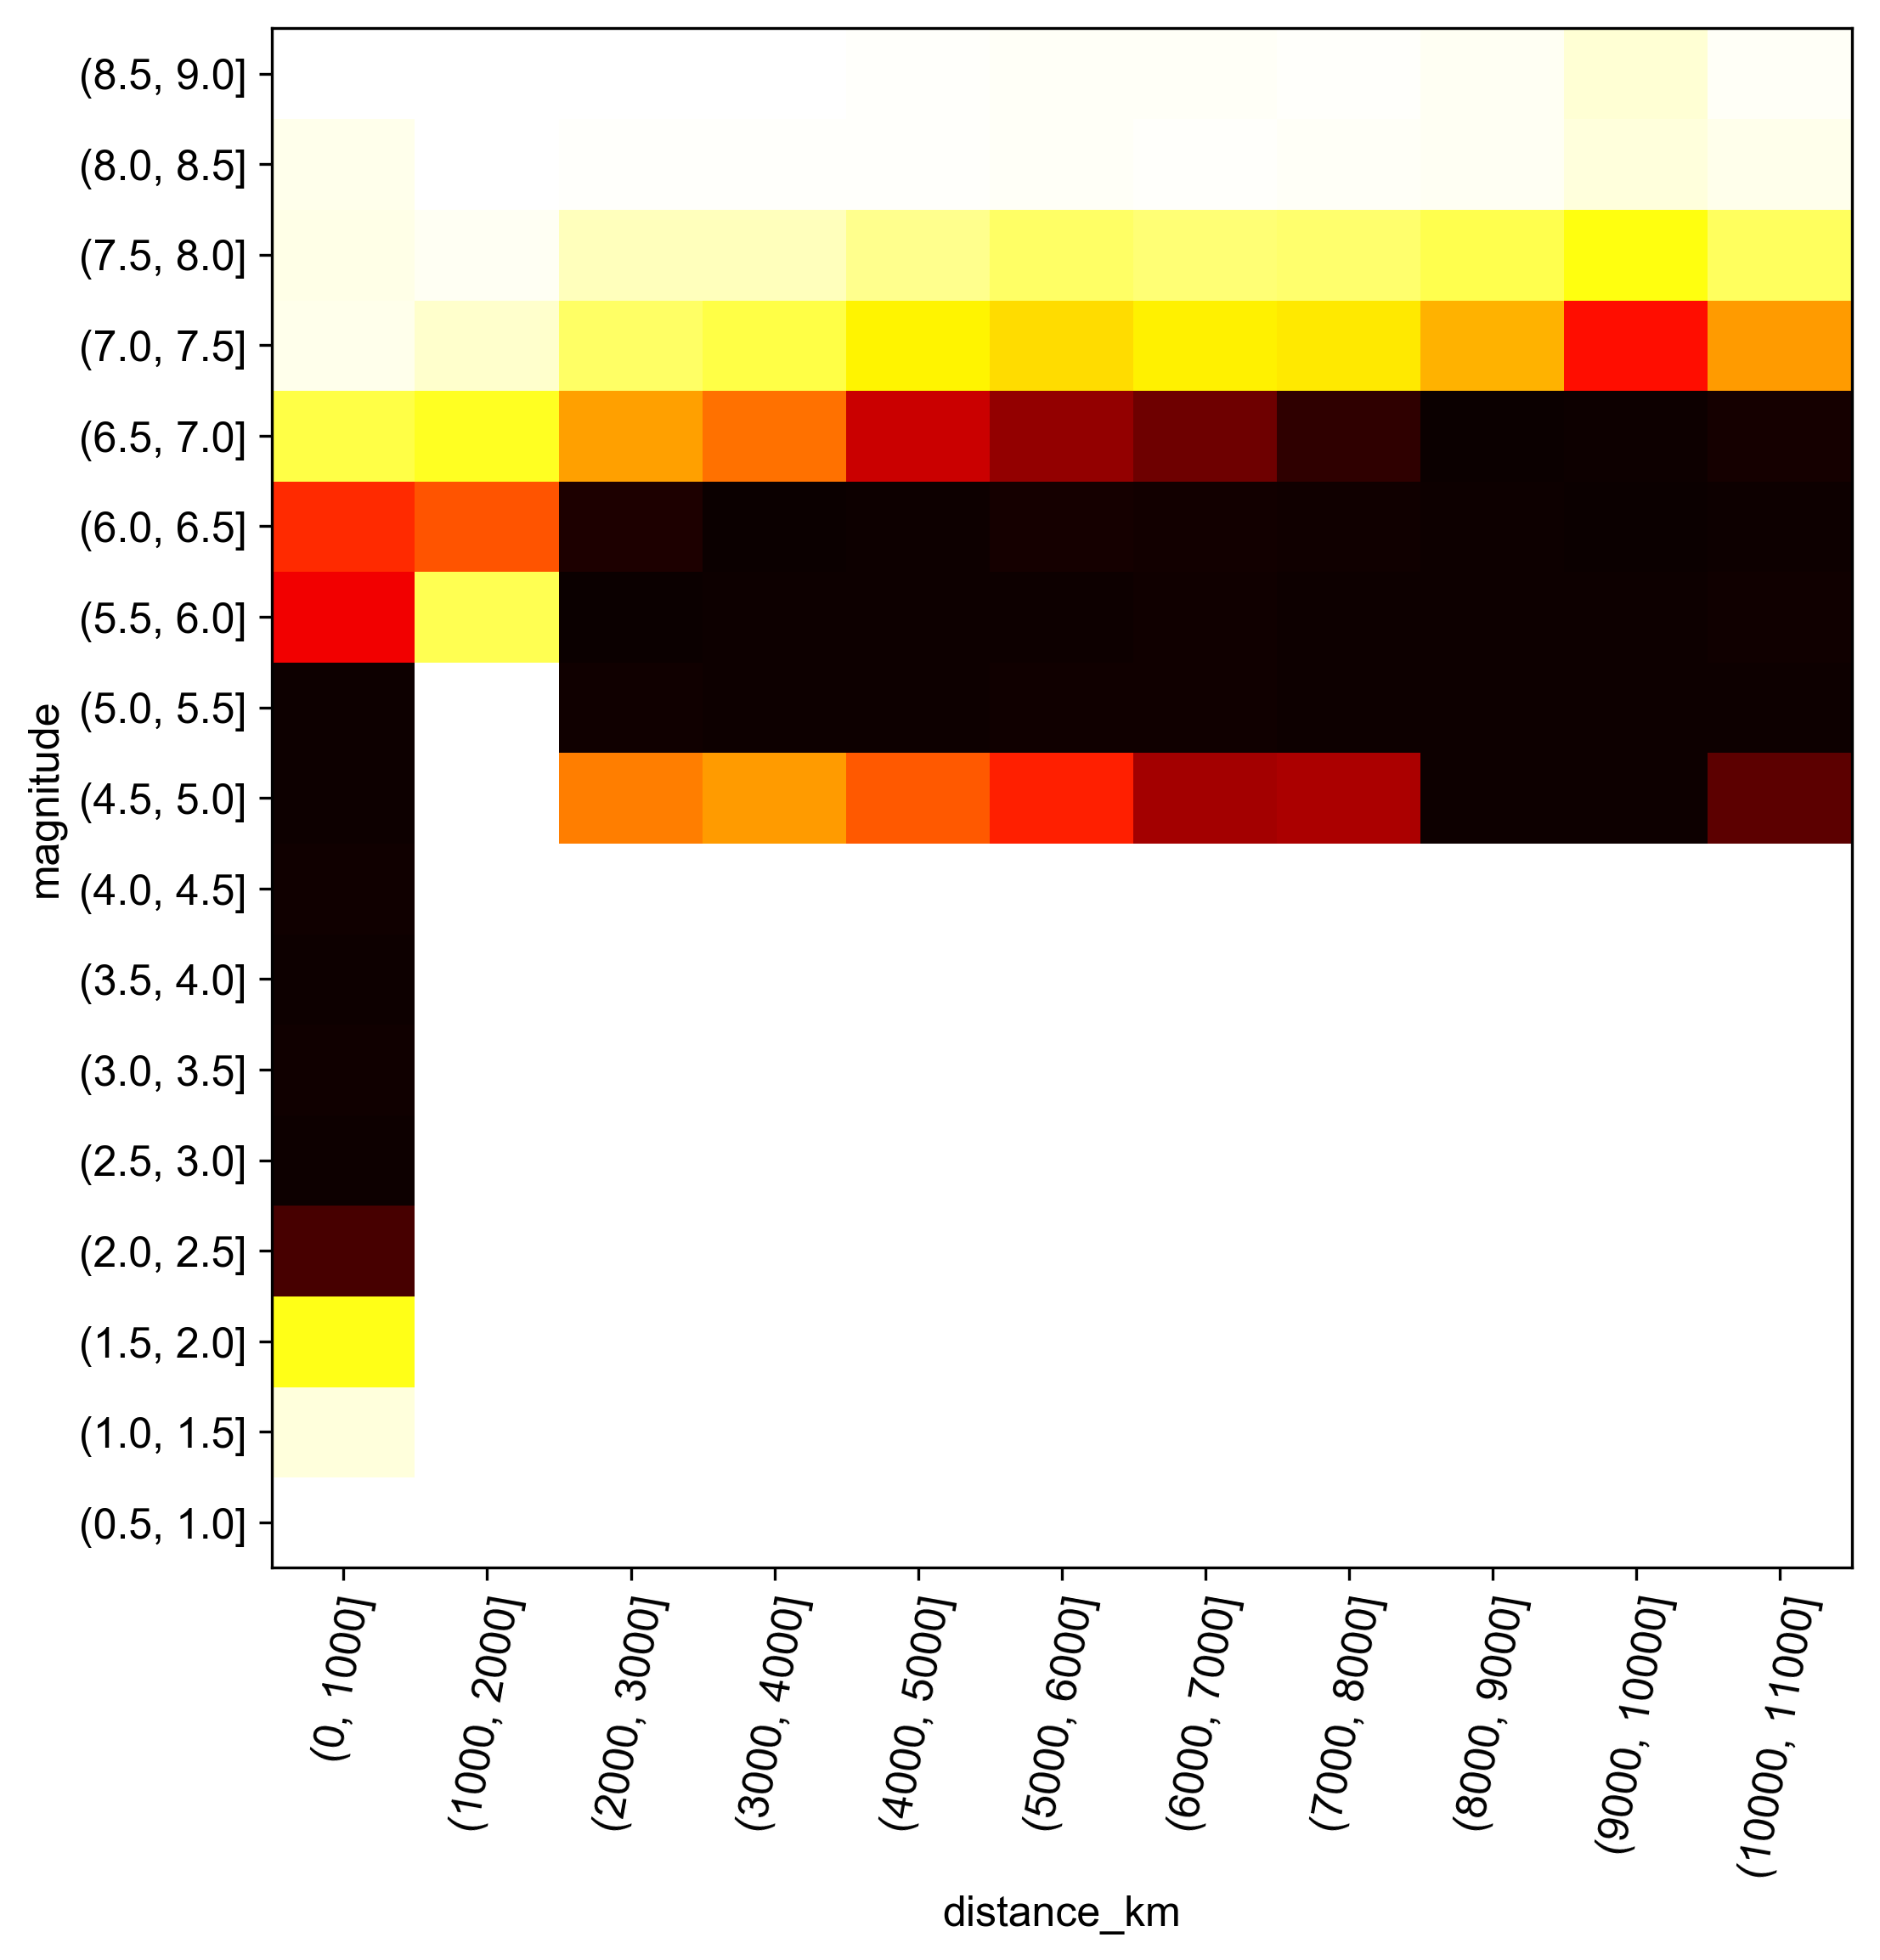

Testset Segment distribution (signal parts ognly)

852,287 total instances (including noise only windows)
432,829 instances


distance_km,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 6000]","(6000, 7000]","(7000, 8000]","(8000, 9000]","(9000, 10000]","(10000, 11000]"
magnitude,,,,,,,,,,,
"(8.5, 9.0]",0,0,3,8,14,77,18,5,30,54,15
"(8.0, 8.5]",6,0,6,19,14,71,11,8,22,39,20
"(7.5, 8.0]",10,0,250,117,223,219,238,246,420,386,488
"(7.0, 7.5]",0,1,260,396,366,606,559,394,607,1038,872
"(6.5, 7.0]",78,91,566,825,1316,1350,1336,1510,2148,3030,2506
"(6.0, 6.5]",268,95,1949,1796,3304,4560,4100,4289,6313,7484,5875
"(5.5, 6.0]",722,98,2052,3178,5969,7656,7109,7422,10283,14267,11237
"(5.0, 5.5]",2516,0,2932,3940,4723,4964,6437,7068,13755,17515,11741
"(4.5, 5.0]",10196,0,591,700,726,1077,1315,1238,2402,2964,2118


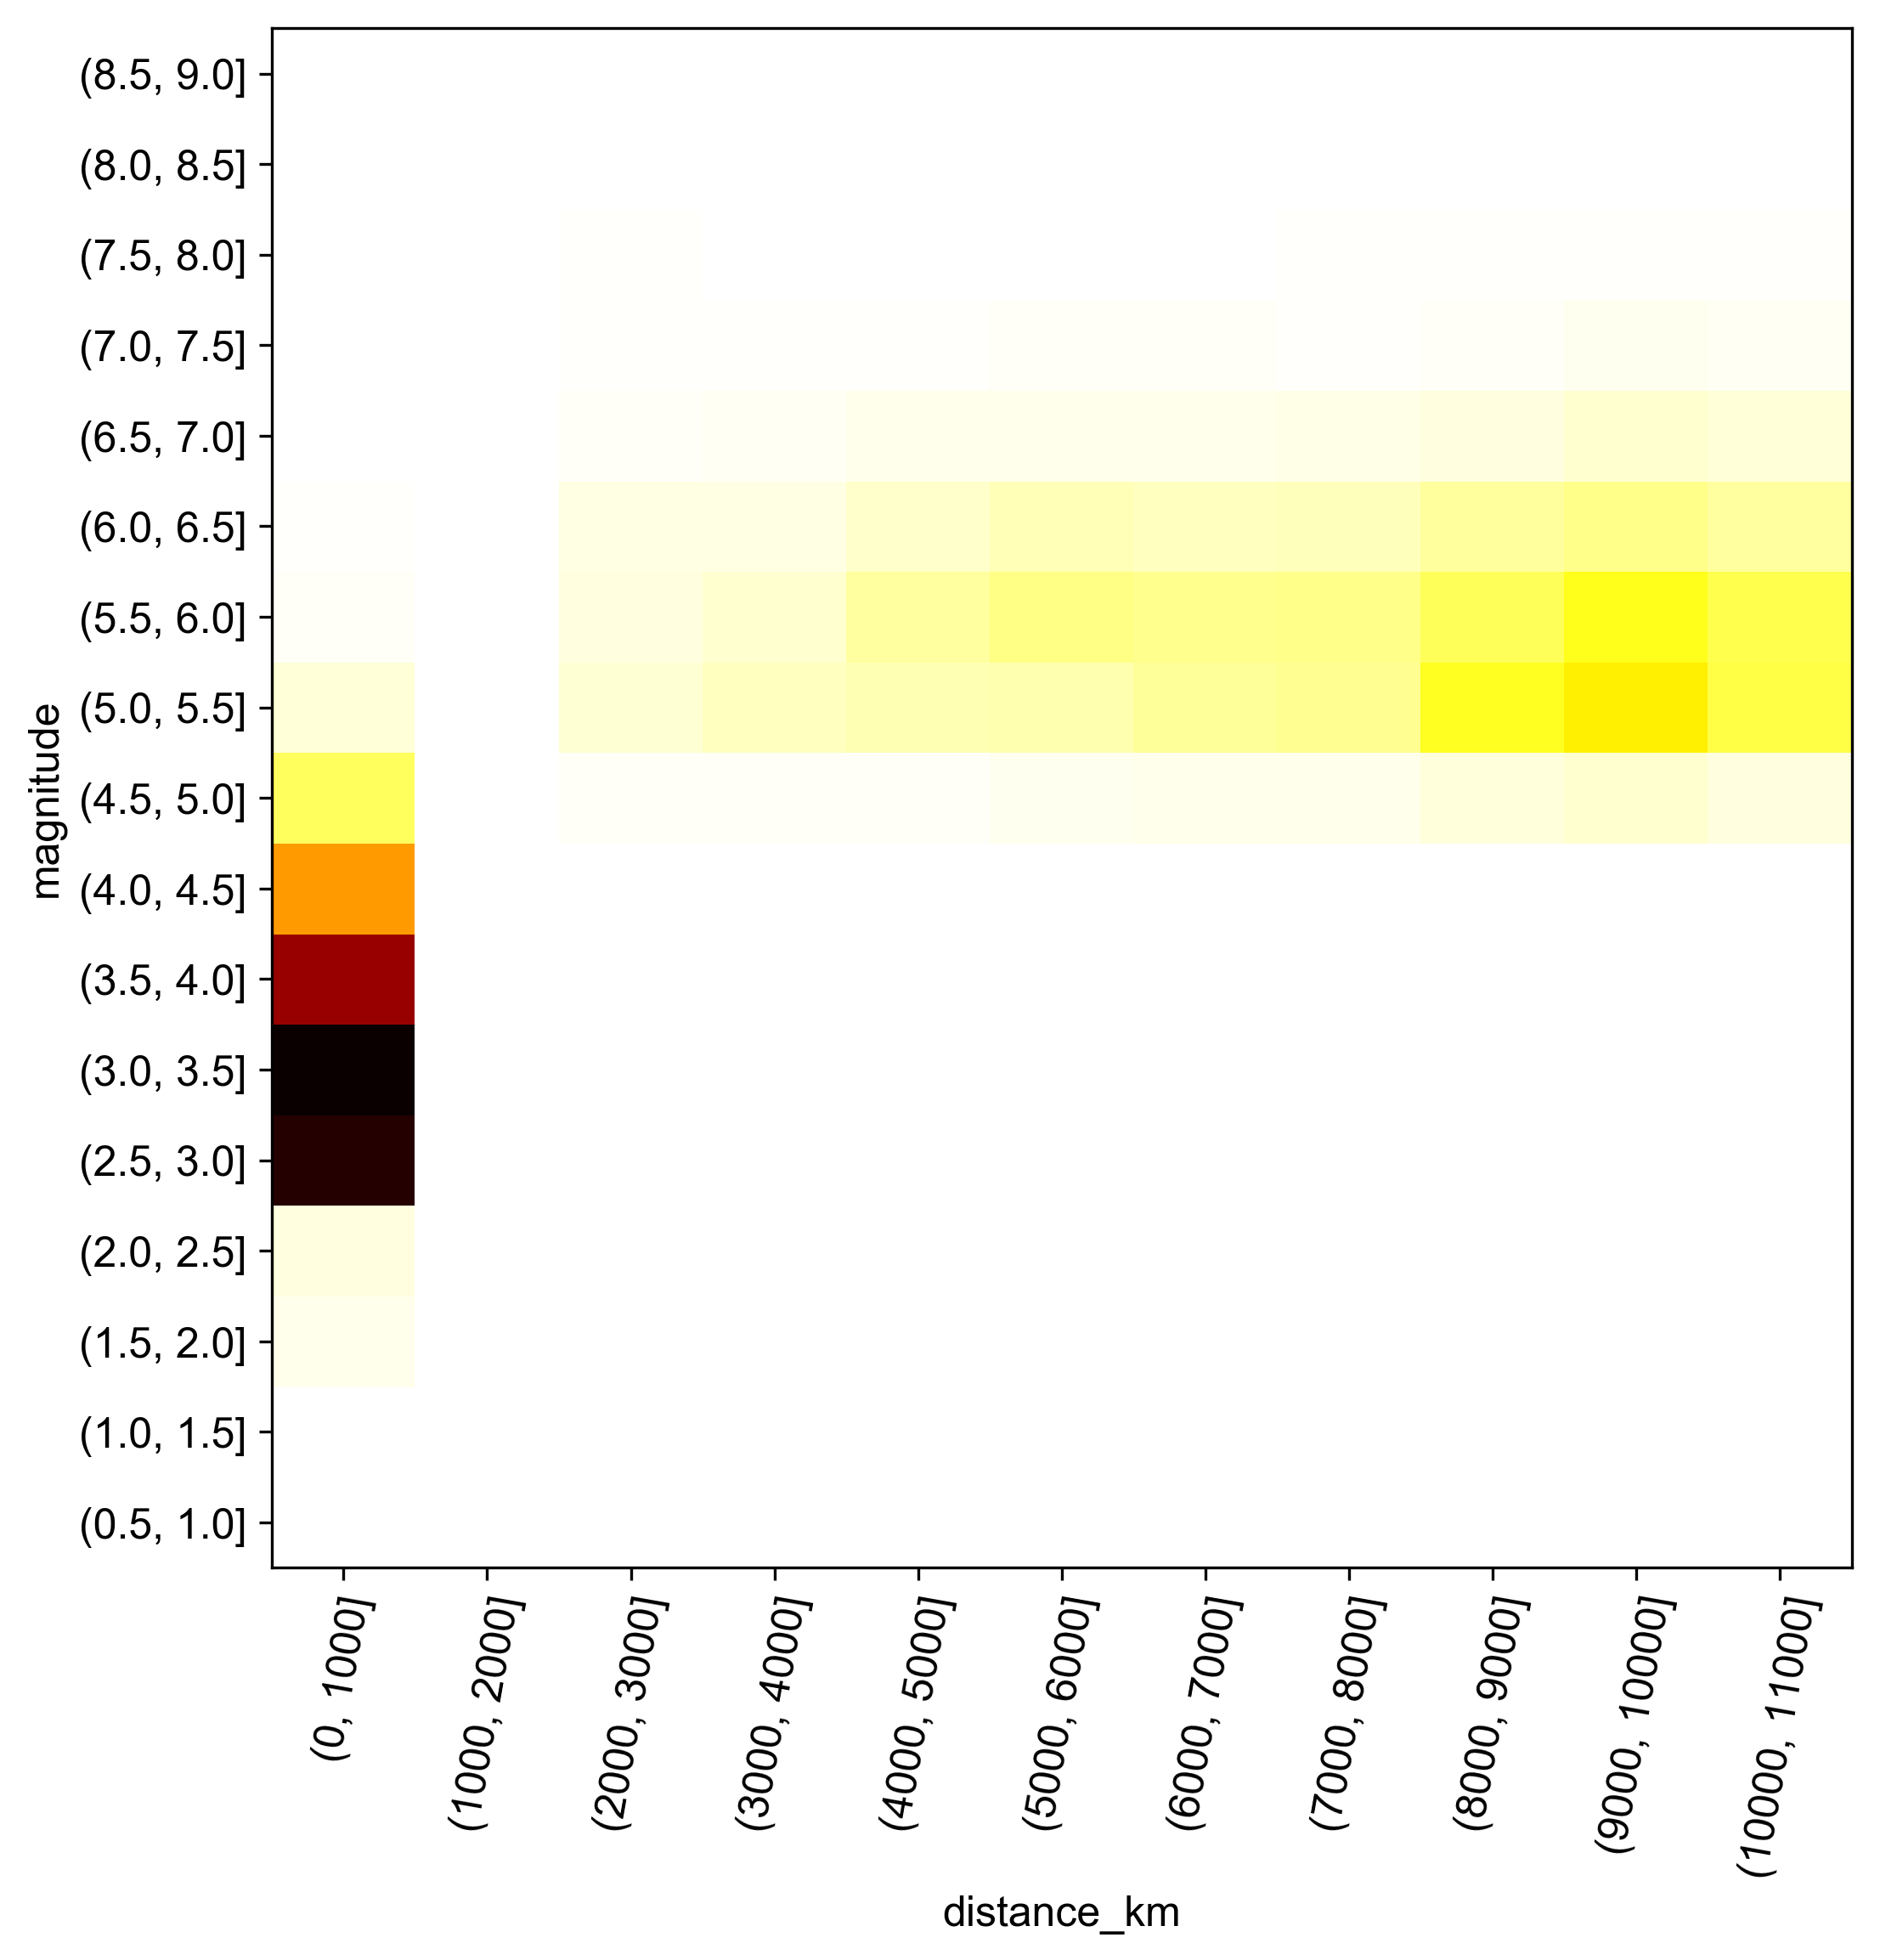

Trainingset (old) Segment distribution (signal parts ognly)

1,892,367 total instances (including noise only windows)
1,018,971 instances


distance_km,"(0, 1000]","(1000, 2000]","(2000, 3000]","(3000, 4000]","(4000, 5000]","(5000, 6000]","(6000, 7000]","(7000, 8000]","(8000, 9000]","(9000, 10000]","(10000, 11000]"
magnitude,,,,,,,,,,,
"(8.5, 9.0]",0,0,16,17,27,45,44,30,77,220,40
"(8.0, 8.5]",99,0,19,26,34,45,32,49,68,184,110
"(7.5, 8.0]",95,0,316,347,580,778,690,741,896,1217,809
"(7.0, 7.5]",0,0,698,929,1363,1544,1395,1437,1855,3094,2039
"(6.5, 7.0]",97,0,1717,2342,3594,4005,4283,4751,5402,6408,4945
"(6.0, 6.5]",996,0,4042,5861,8637,10059,10149,12019,15045,17431,13073
"(5.5, 6.0]",2779,0,7541,11298,16152,18242,20218,22270,28706,35761,24845
"(5.0, 5.5]",7652,0,10849,12508,16155,18329,21151,22168,32172,41378,27245
"(4.5, 5.0]",37398,0,2245,2036,2527,2949,3882,3823,5109,7020,4414


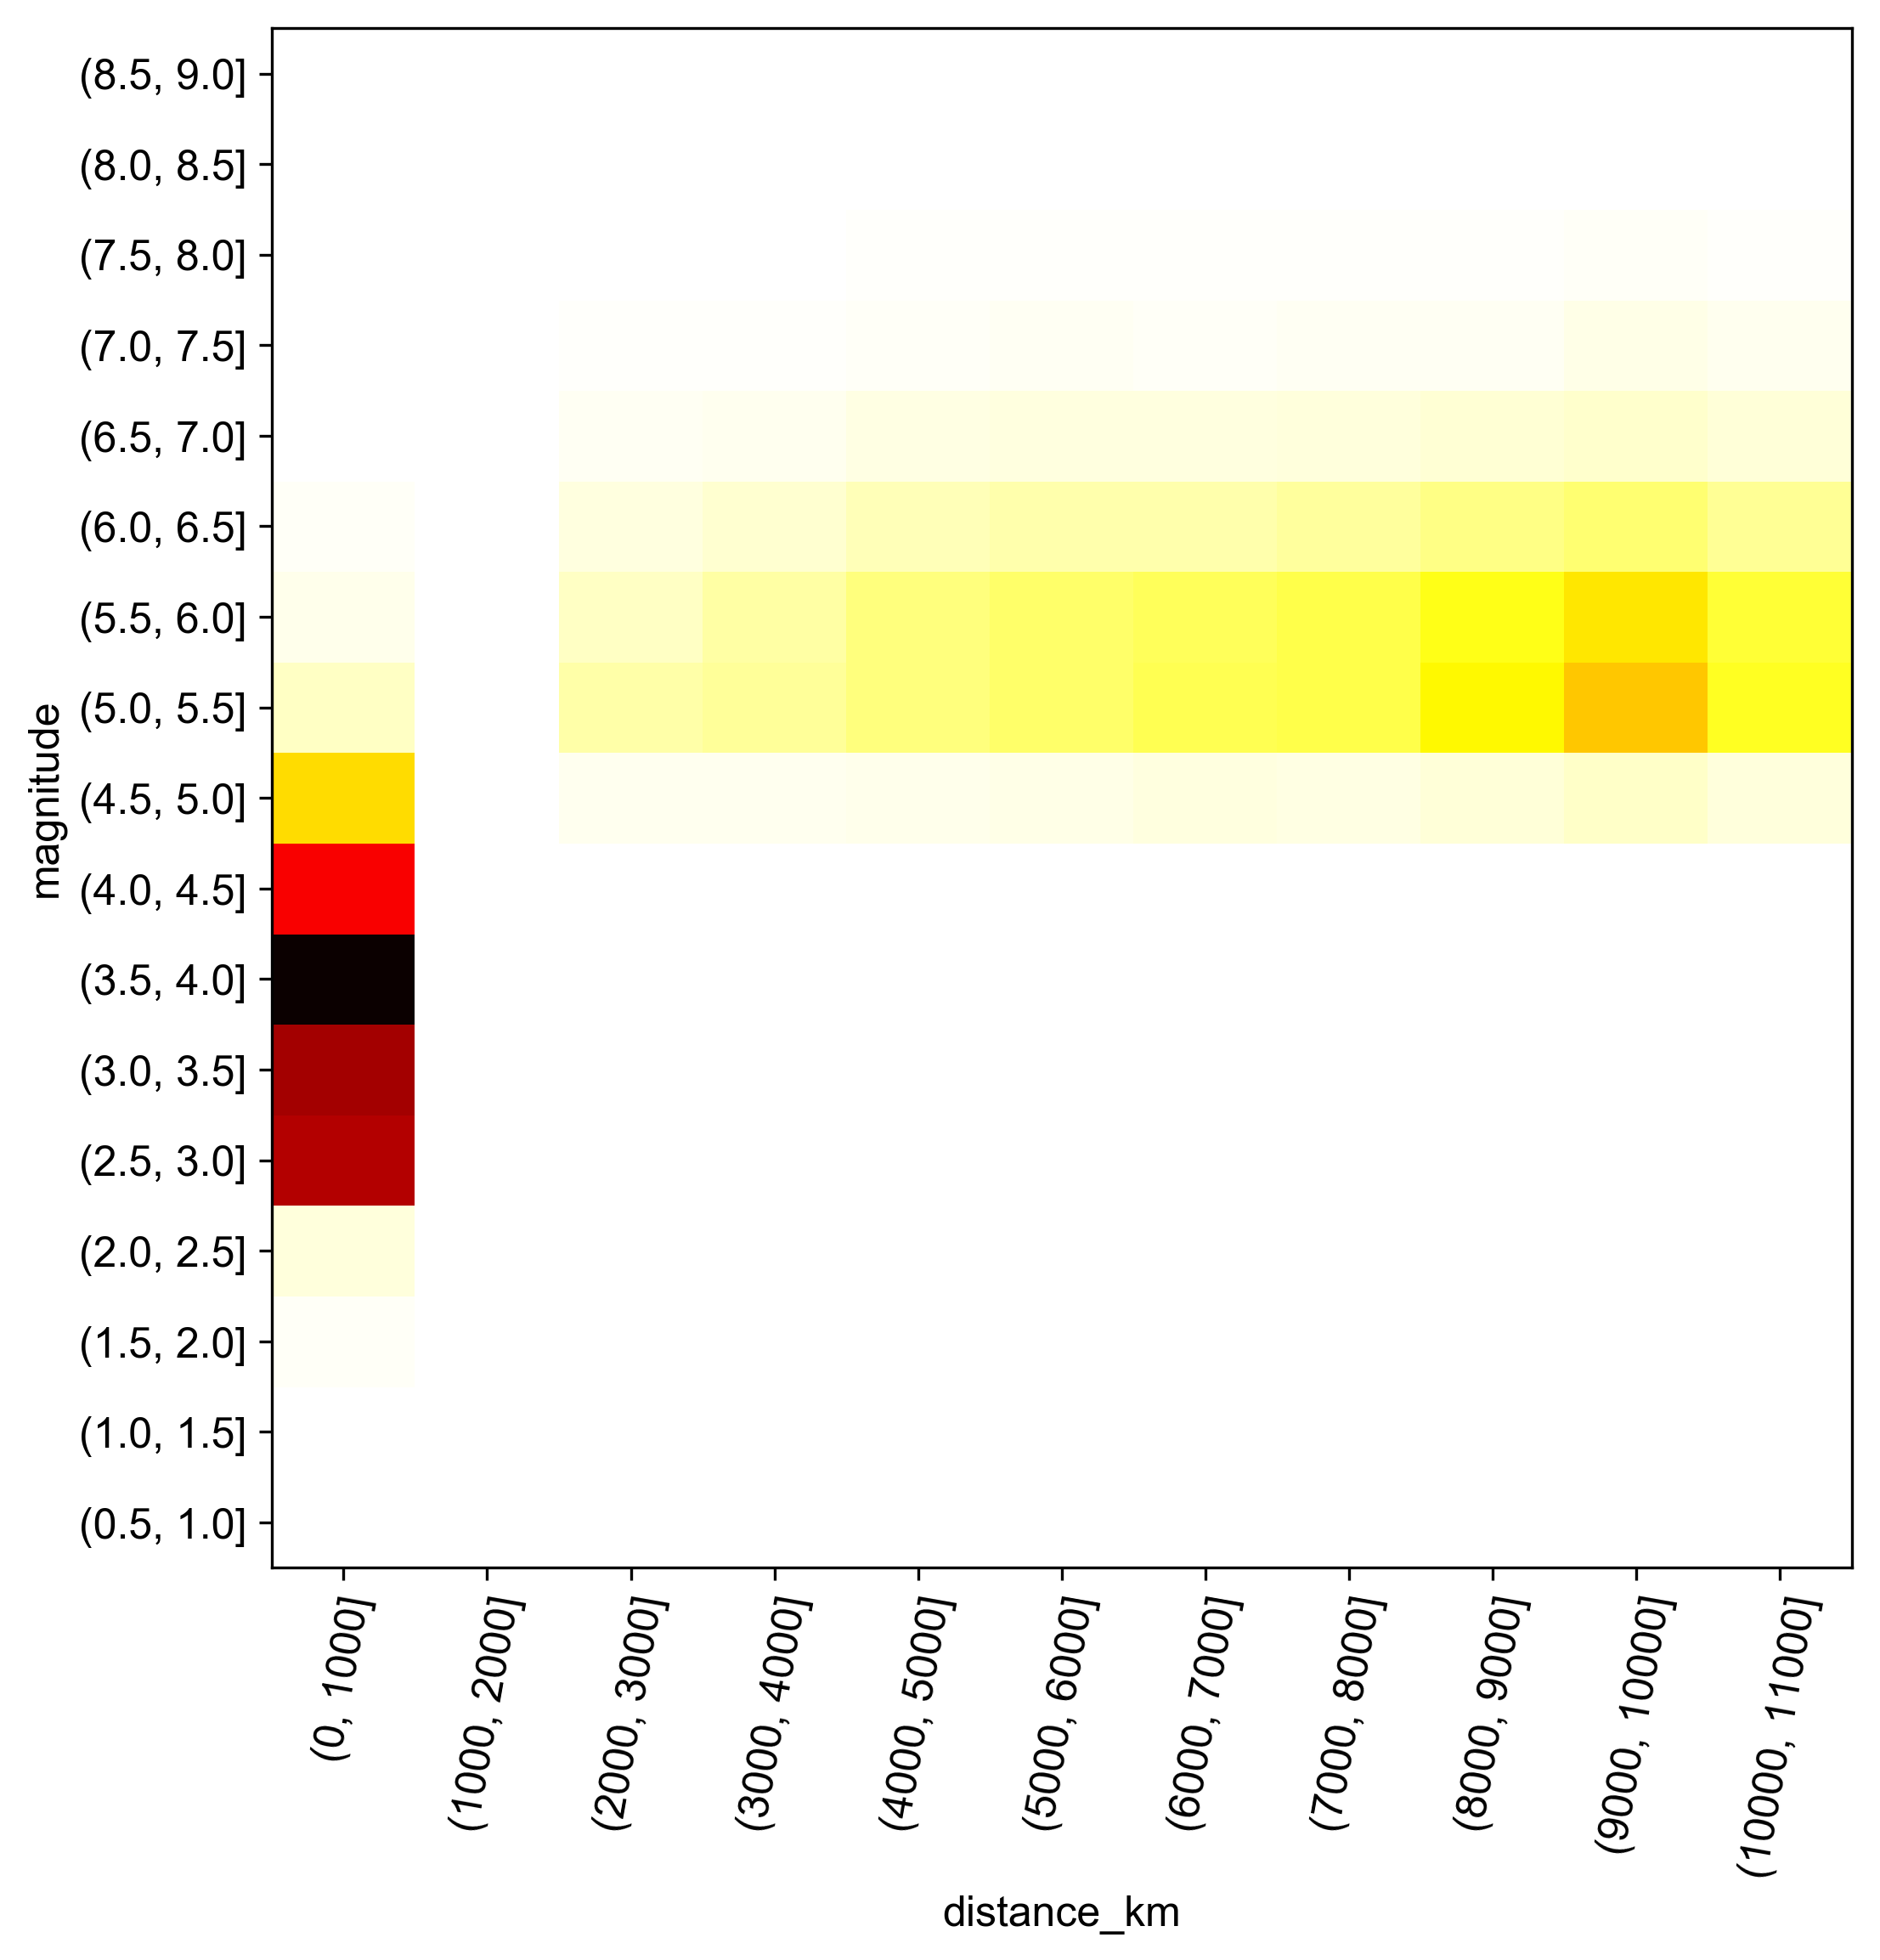

(SAVE_FIGURES=False)


In [20]:
printhtml('<h3>Train set distance / magnitude heatmap</h3>')

printhtml(f'<h4>Trainingset Segment distribution (signal parts ognly)</h4>')
_ = pd.read_hdf(join(DATASETS_DIR, TRAINSET_U), columns=['magnitude', 'distance_km',
                                                                       'window_type'])
print(f"{len(_):,d} total instances (including noise only windows)")
hmttest = magdist(_[_.window_type])

printhtml(f'<h4>Testset Segment distribution (signal parts ognly)</h4>')
_ = pd.read_hdf(join(DATASETS_DIR, TESTSETNAME_U), columns=['magnitude', 'distance_km',
                                                                       'window_type'])
print(f"{len(_):,d} total instances (including noise only windows)")
hmttest = magdist(_[_.window_type])

printhtml(f'<h4>Trainingset (old) Segment distribution (signal parts ognly)</h4>')
_ = pd.read_hdf(join(DATASETS_DIR, TRAINSET), columns=['magnitude', 'distance_km',
                                                                       'window_type'])
print(f"{len(_):,d} total instances (including noise only windows)")
hmttest = magdist(_[_.window_type])

    # samey(_)
del _
savefig(fig, 'tsets_segments_freqdist')
plt.show()    

In [5]:
printhtml('<h3>Loading evaluation dataframe</h3>')
eval_df = read_eval_df('evaluationmetrics.hdf') #  read_summary_eval_df()

for setname in [TESTSETNAME_U, TESTSETNAME12]:
    print()
    printhtml('<h4>Testset: "%s". Best models under "average precision score" (APS)</h4>' % setname)
    display(eval_df[eval_df.relative_filepath.str.endswith(os.sep + setname)].
            sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Loading evaluation dataframe

NameError: name 'TESTSETNAME12' is not defined


(SAVE_FIGURES=False)


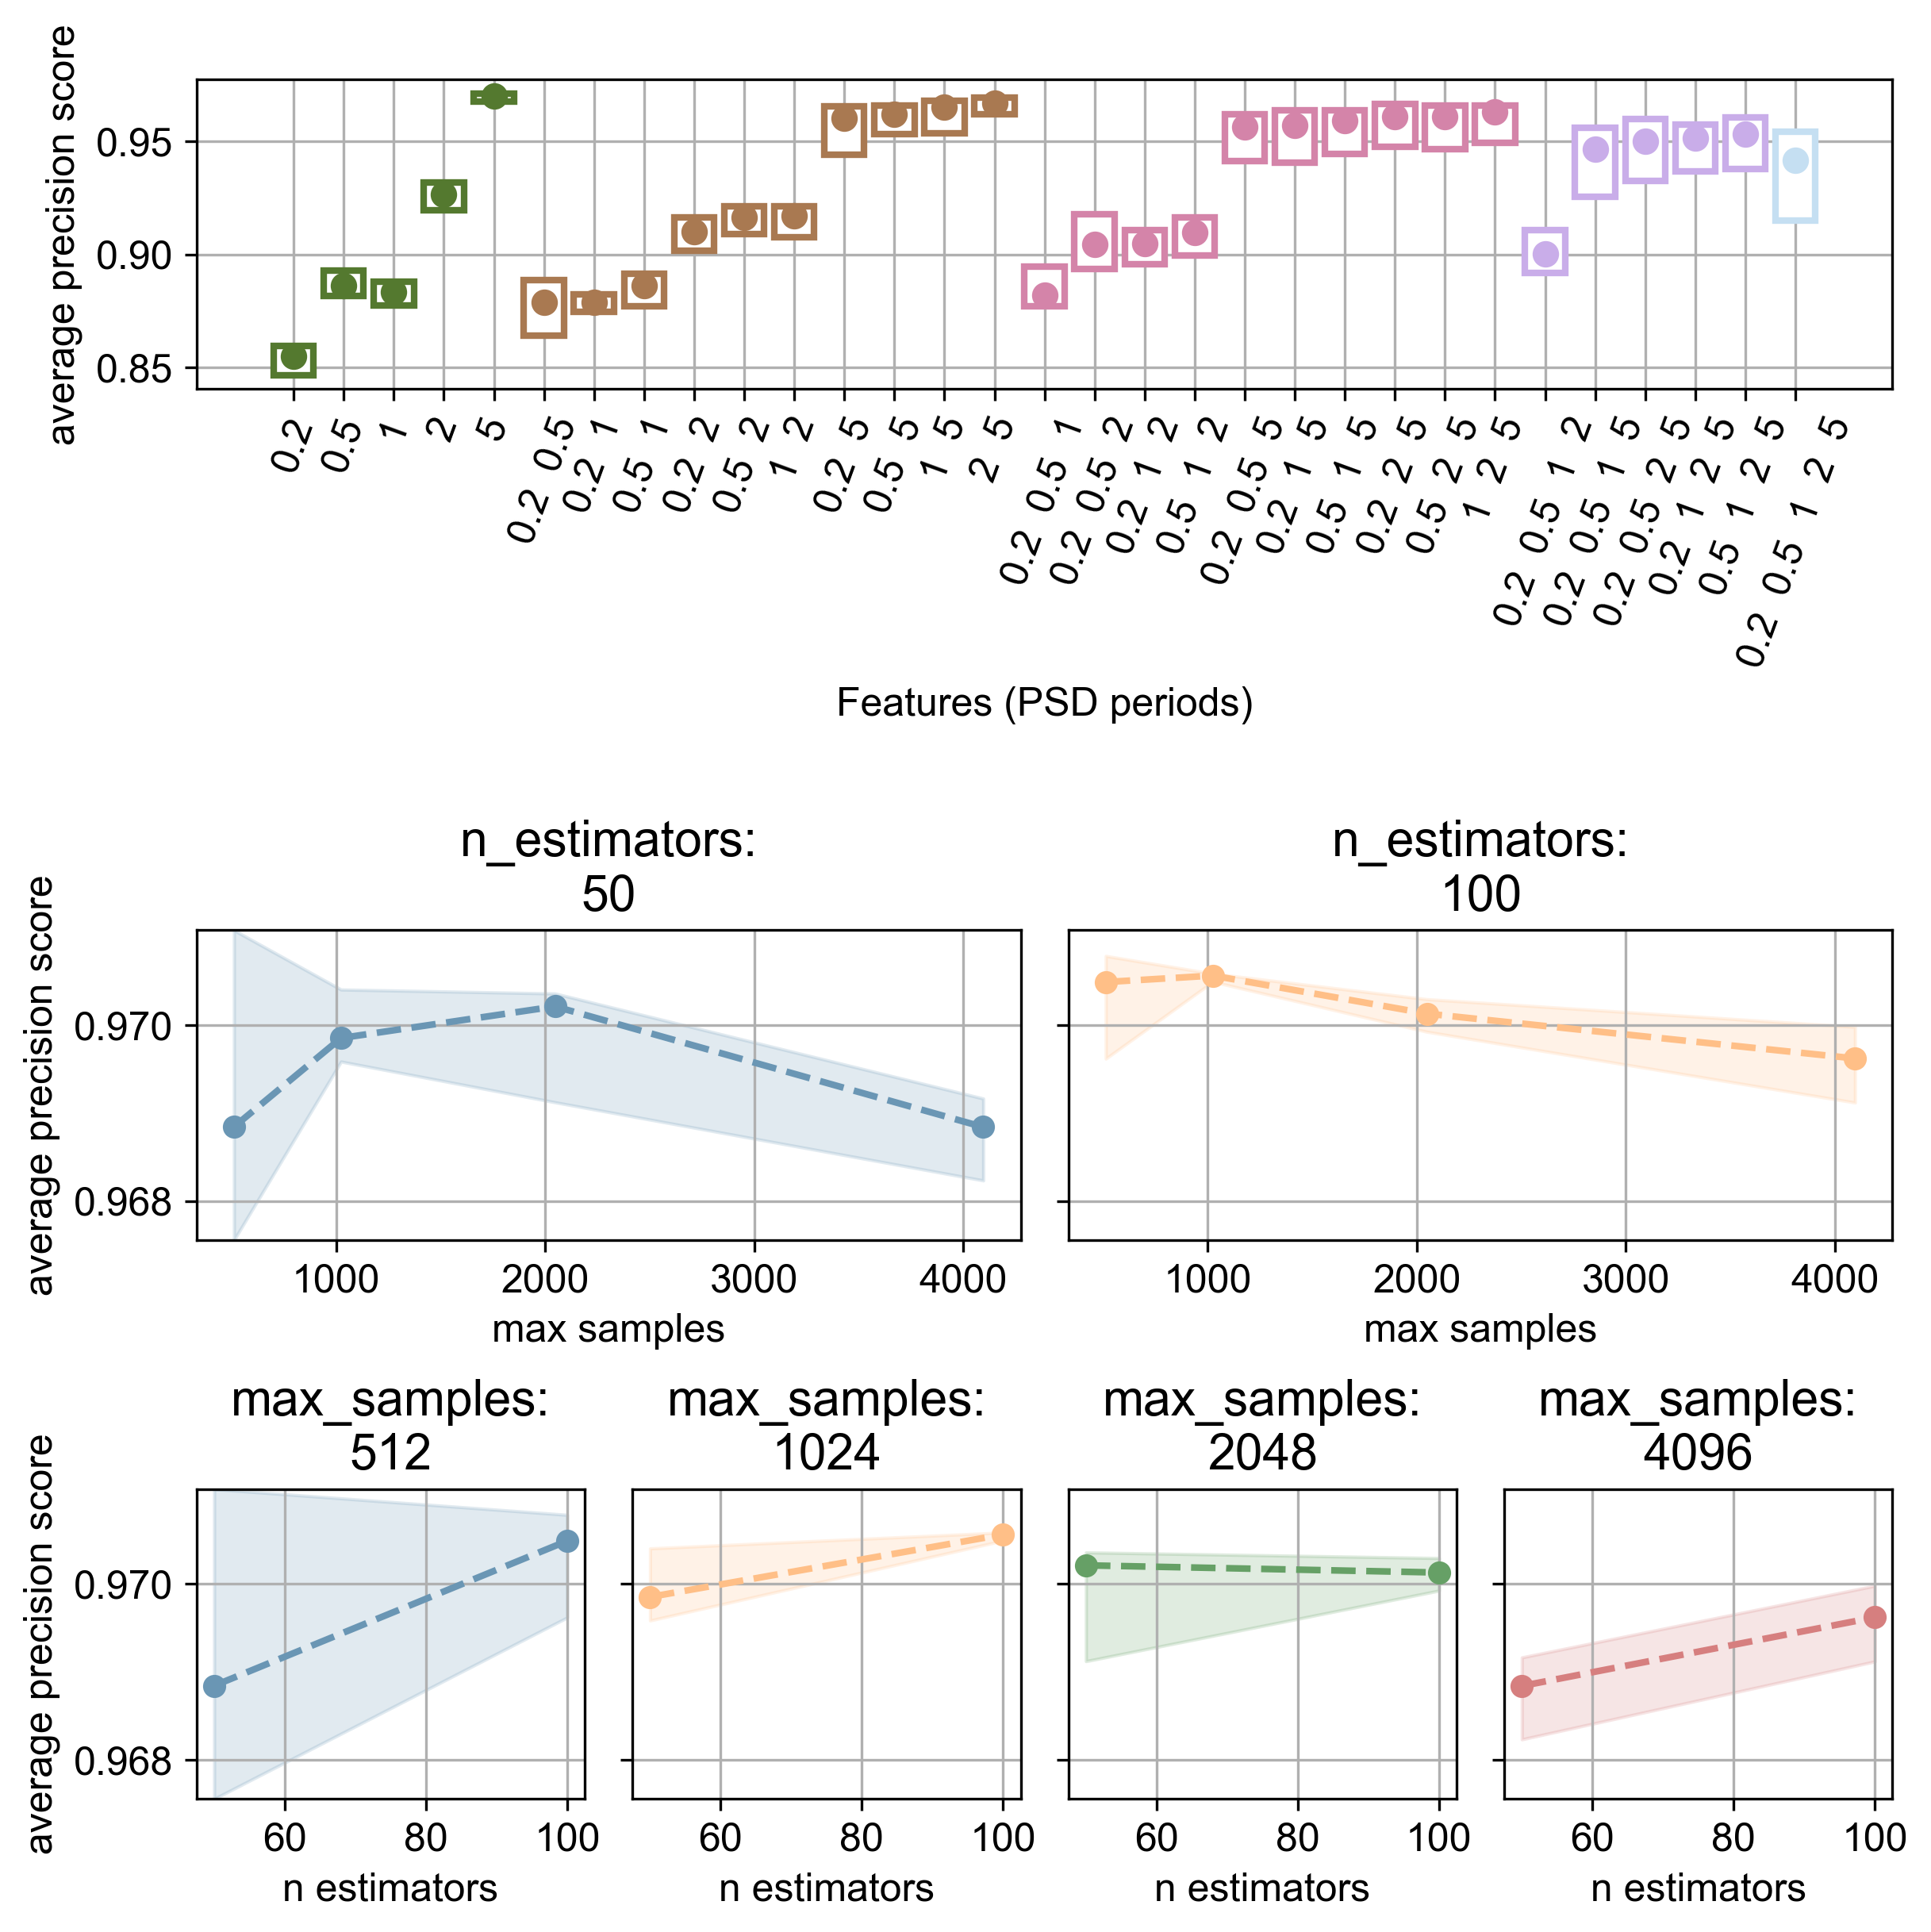

In [25]:
# sets = [(TESTSETNAME1, 'feats_and_hp_testset1'), (TESTSETNAME2, 'feats_and_hp_testset2')]
sets = [(TESTSETNAME_U, 'testset_uniform')]  #, (TESTSETNAME2, 'feats_and_hp_testset2')]

SCORE = 'average_precision_score'
# ne, ms = [50, 100, 200], [512, 1024, 2048, 4096, 8192, 16384]
ne, ms = [50, 100], [512, 1024, 2048, 4096]
for setname, filename in sets:
    print()
    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(4, max(len(ne), len(ms)), height_ratios=[10, 1, 10, 10])
    eval_df_ = eval_df[eval_df.relative_filepath.str.endswith(os.sep + setname)]
    axs = fig.add_subplot(gsp[0, :])
    plot_feats_vs_evalmetrics(eval_df_, [SCORE], show=[axs])
    
    eval_df_ = eval_df_[eval_df_.feats.str.match('psd@5sec')]  # eval_df_[eval_df_.feats.str.contains('psd@5sec')]
    # eval_df_ = eval_df_[eval_df_.feats == 'psd@5sec']
    dfmin, dfmedian, dfmax = get_hyperparam_dfs(eval_df_, SCORE, n_estimators=ne, max_samples=ms)

    
    axs = [fig.add_subplot(gsp[2, 2*i: 2*i+2]) for i in range(len(ne))]
    plot_hyperparam_dfs(dfmin, dfmedian, dfmax, ylabel=SCORE.replace('_', ' '), show=axs)

    axs = [fig.add_subplot(gsp[3, i]) for i in range(len(ms))]
    plot_hyperparam_dfs(dfmin.T, dfmedian.T, dfmax.T, ylabel=SCORE.replace('_', ' '), show=axs)
    
    savefig(fig, filename)

Analyzing HP and time complexity (aka time performance) for psd@5sec

Getting a random segment and computing the time required for converting to PSD

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Trace length: 0:04:00.606000


Time required to convert ONE stream of 240.606000 seconds into a single scalar PSD@5s: 0.07057690620422363

With 100,000 instances it would mean aproximately (H:m:s.msec): 1:57:37.690620

Plotting Time performances

(Performances on 100,000 PSD periods computed at 5 seconds)

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Saving figure to "~/Nextcloud/rizac/outliers_paper/paper_figures/feat5sec_hp_and_time_perf_bothsets.png"

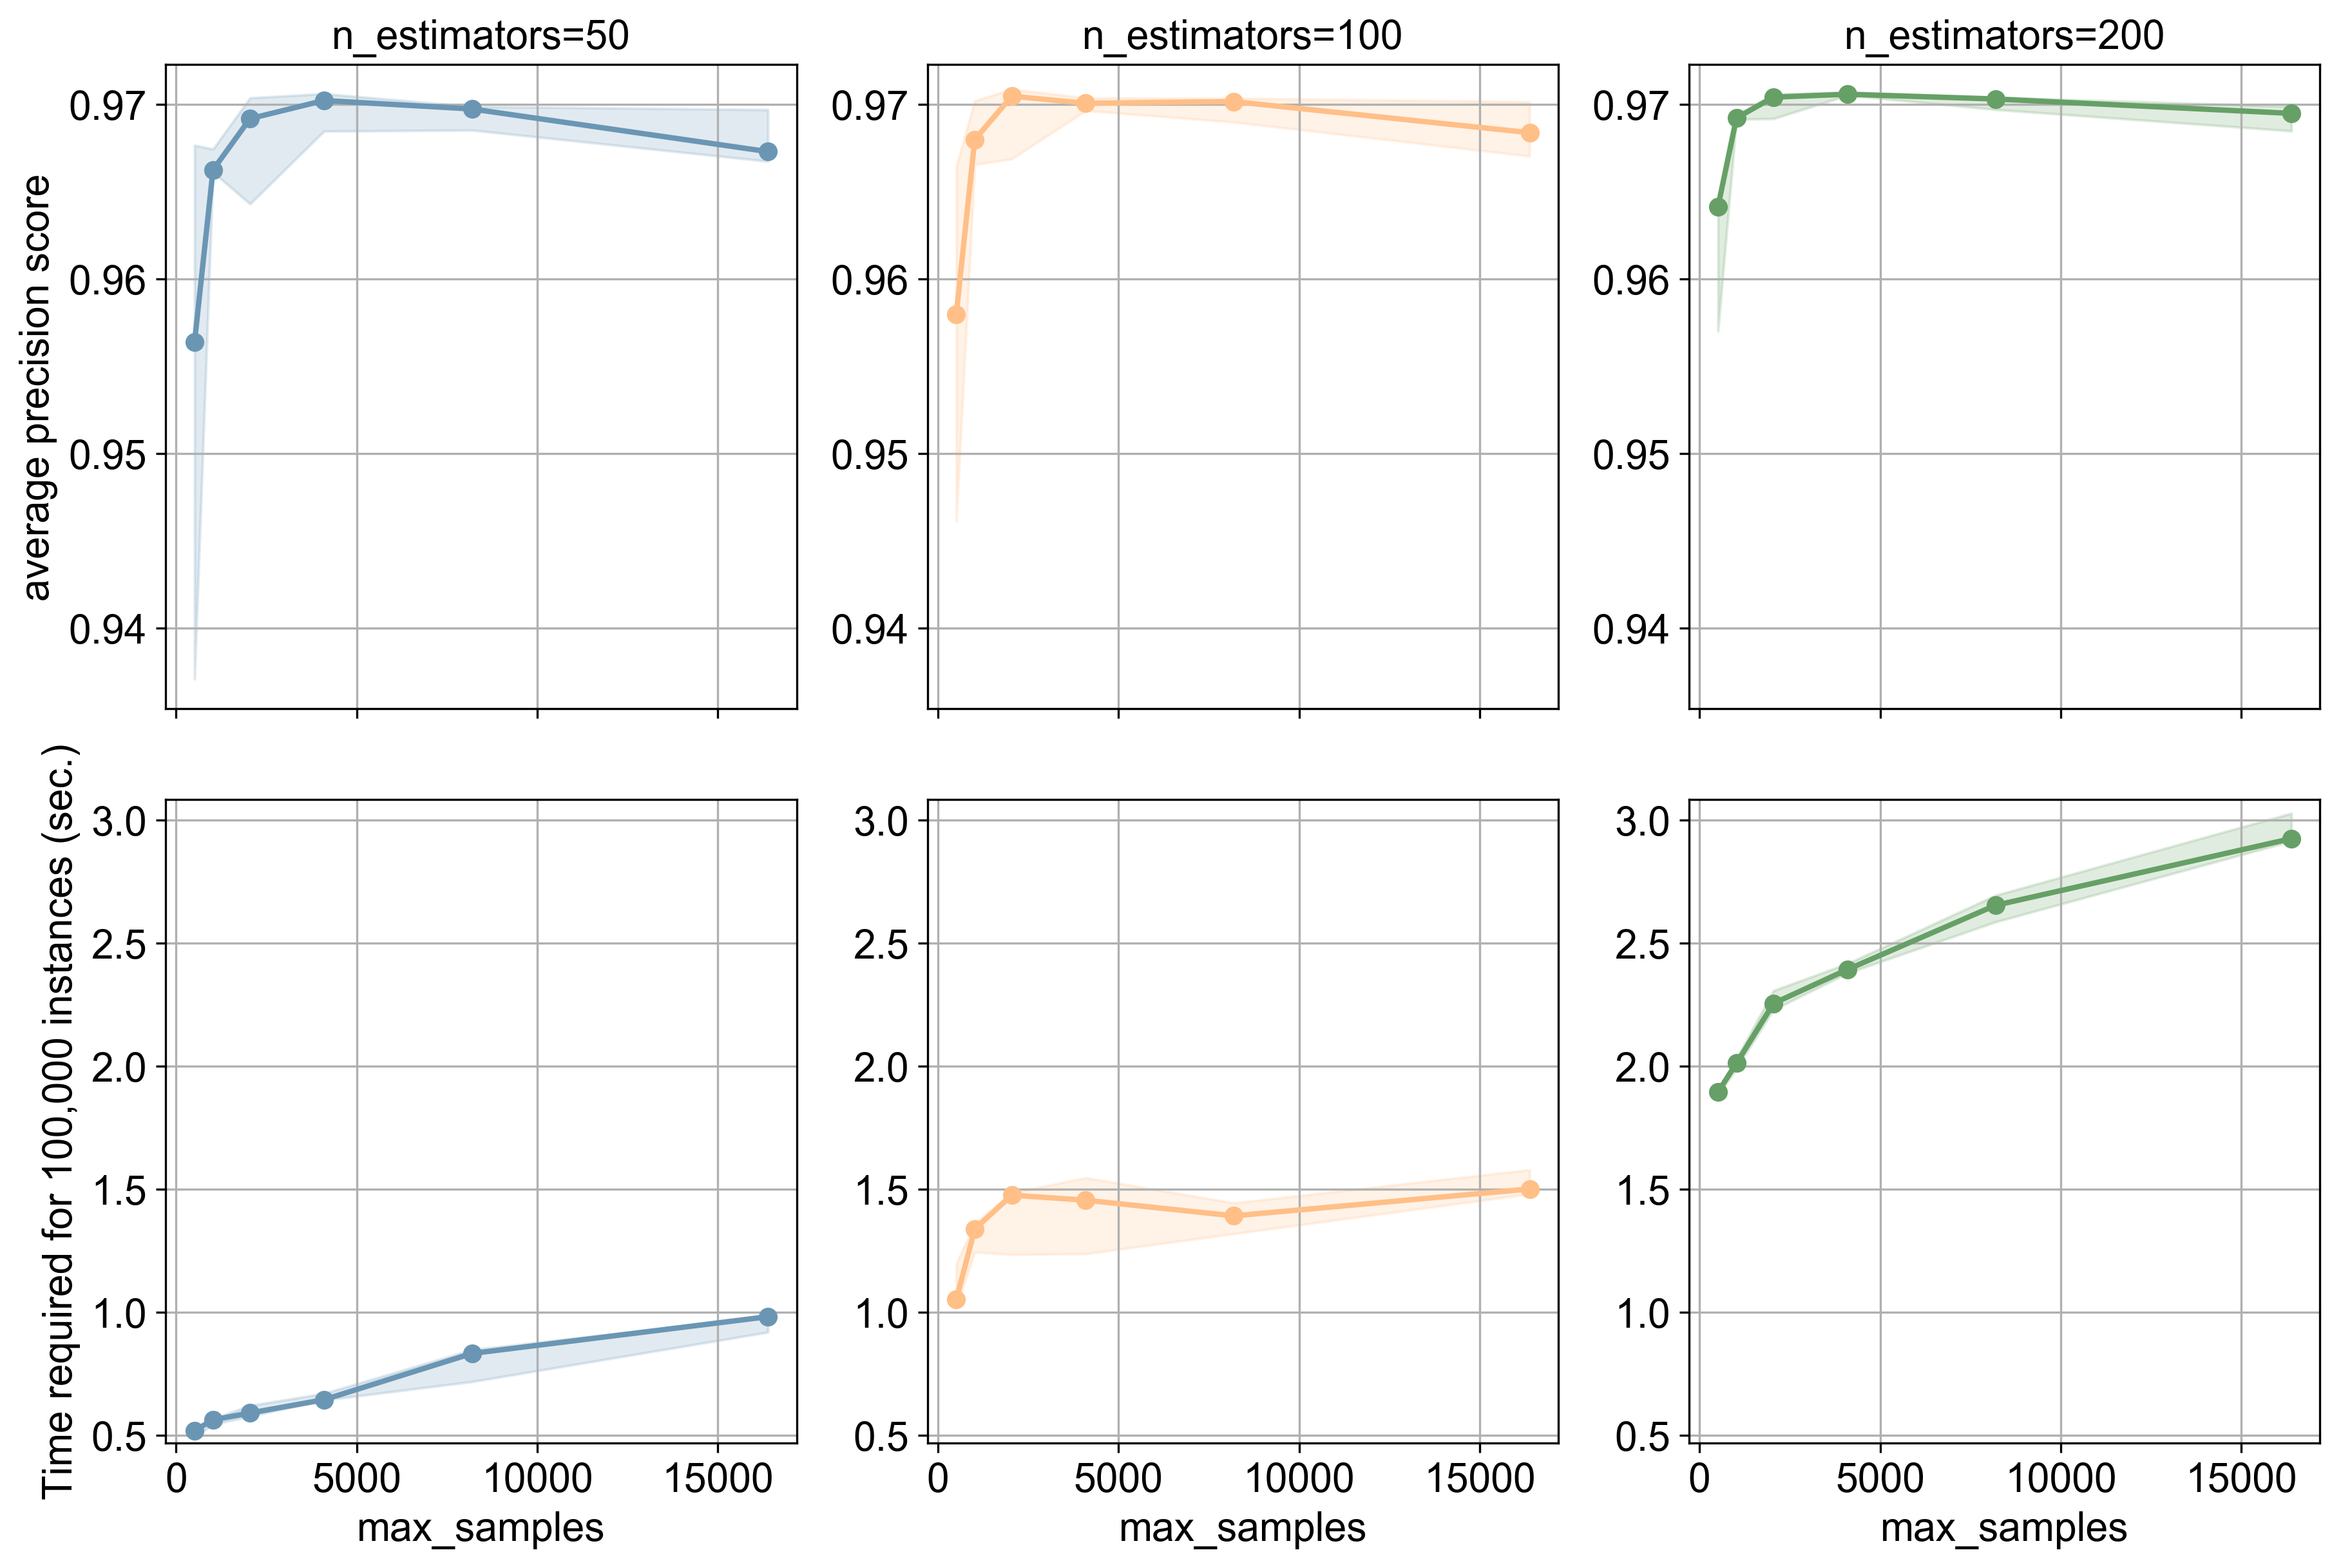

In [7]:
printhtml('<h3>Analyzing HP and time complexity (aka time performance) for psd@5sec</h3>')

printhtml('<h3>Getting a random segment and computing the time required for converting to PSD</h3>')


sess = get_db_session(1)
try:
    # this is TOO COSTLY: 
    #  data = sess.query(Segment.data, Station.inventory_xml).join(Segment.station).\
    #      filter(Segment.has_data).order_by(Segment.data.desc()).limit(1).first()

    # I EXECUTED THE QUERY ON THE WEB PAGE:
    #
    # select segments.id, length(segments.data) from segments where segments.data is not null and segments.maxgap_numsamples < 0.5 and segments.maxgap_numsamples > -0.5 order by length(segments.data) desc limit 5
    #
    # AND GOT THESE IDS (with data length sorted descending, first 5 results):
    # 2590524 2392064
    # 2581456 2387968
    # 2592296 2387968
    # 2598859 2387968
    # 2597781 2387968
    # so:
    data = sess.query(Segment.data, Station.inventory_xml).join(Segment.station).\
                  filter(Segment.id == 2590524).one()
    
finally:
    sess.close()

# read trace:
from obspy import read, read_inventory
from io import BytesIO
stream = read(BytesIO(data[0]))
inv_xml = loads_inv(data[1])
raw_trace = sorted(stream, key=lambda _ : _.stats.endtime - _.stats.starttime, reverse=True)[0]
print('Trace length: %s' % str(timedelta(seconds=raw_trace.stats.endtime - raw_trace.stats.starttime)) )


# defining the functions for converting to specturm (as used in the stream2segment config, these
# might be optimized)

N_PERIODS = 100000

# estimate the time required for computing the PSD @ 5 seconds
t = time.time()
ppsd(raw_trace, inv_xml, 5)
t = time.time() - t
printhtml('<h4> Time required to convert ONE stream of %f seconds into a single scalar PSD@5s: %s</h4>' %
         (raw_trace.stats.endtime - raw_trace.stats.starttime, t))
printhtml(f'<h4> With {N_PERIODS:,} instances it would mean aproximately (H:m:s.msec): %s' %
         str(timedelta(seconds=N_PERIODS*t)))




plt.rcParams['figure.figsize'] = (12, 8)

printhtml('<h3>Plotting Time performances</h3>')
printhtml(f'(Performances on {N_PERIODS:,} PSD periods computed at 5 seconds)')

# let's see how much different models with different random state have differences are actually
# psdvals = np.arange(-250, 0, .1)
psdvals = np.linspace(-250, 0, N_PERIODS, endpoint=True)
psdvals_ = psdvals.reshape(len(psdvals), 1)

maxs = np.unique(eval_df.max_samples.values)
nest = np.unique(eval_df.n_estimators.values)



fig = plt.figure(constrained_layout=True)
gsp = fig.add_gridspec(2, len(nest))

axss = [[], []]
colors = get_colors(len(nest))
_baralign = -500

pbar = progressbar(len(maxs) * len(nest))

for idx_, (ne, c) in enumerate(zip(nest, colors)):
    eval_df_ = eval_df[(eval_df.feats == 'psd@5sec')  & (eval_df.n_estimators == ne) &
                       # this end is only needed to restrict the models to a single test set, otherwise
                       # we compute the same model more than once which does not make much sense.
                       # Also, we want to report the APSs so we choose to report those of the
                       # two models combined:
                       (eval_df.relative_filepath.str.endswith(os.sep + TESTSETNAME12))]
    mintimes = []
    maxtimes = []
    mediantimes = []
    minaps = []
    maxaps = []
    medianaps = []
    apss = []
    for ms in maxs:
        pbar.update(1)
        # display('Processing n_estimators=%d, max_samples=%d' % (ne, ms))
        times = []
        aps_ = []
        for rowtuple in eval_df_[eval_df_.max_samples == ms].itertuples(index=False):
            clf = load_clf(dirname(rowtuple.relative_filepath) + '.sklmodel')
            t = time.time()
            current_scores = -clf.score_samples(psdvals_)
            t = time.time() - t
            times.append(t)
            aps_.append(rowtuple.average_precision_score)
        mintimes.append(np.nanmin(times))
        mediantimes.append(np.nanmedian(times))
        maxtimes.append(np.nanmax(times))
        minaps.append(np.nanmin(aps_))
        medianaps.append(np.nanmedian(aps_))
        maxaps.append(np.nanmax(aps_))
    
    title = 'n_estimators=%d' % ne

    axs = fig.add_subplot(gsp[0, idx_])
    axs.plot(maxs, medianaps, linewidth=2, marker='o', color=c, label='n_estimators=%d' % ne)
    axs.fill_between(maxs, minaps, maxaps, alpha=0.2, color=c)
    axs.grid()
    axs.set_title(title)
    axs.set_xticklabels([])
    if idx_ == 0:
        axs.set_ylabel('average precision score')
    axss[0].append(axs)

    axs = fig.add_subplot(gsp[1, idx_])
    axs.plot(maxs, mediantimes, linewidth=2, marker='o', color=c, label=title)
    axs.fill_between(maxs, mintimes, maxtimes, alpha=0.2, color=c)
    axs.grid()
    if idx_ == 0:
        axs.set_ylabel(f'Time required for {N_PERIODS:,} instances (sec.)')
    axs.set_xlabel('max_samples')
    axss[1].append(axs)

for _ in axss:
    samex(_)
    samey(_)

filename = 'feat5sec_hp_and_time_perf_bothsets'
savefig(fig, filename)
plt.show()
plt.rcParams['figure.figsize'] = (12, 12)

Plotting best models in details. All metrics computed on test set "uniform_test.hdf"

Grouping models by (n_estimators, max_samples) and keeping those with median average precision score

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
1592,IsolationForest,psd@5sec,100,1024,11,0.970564,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
1604,IsolationForest,psd@5sec,100,512,11,0.970490,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1599,IsolationForest,psd@5sec,50,2048,11,0.970213,0.737760,0.975100,0.559445,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf
1596,IsolationForest,psd@5sec,100,2048,11,0.970131,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
1595,IsolationForest,psd@5sec,50,1024,25,0.969853,0.739561,0.975201,0.574039,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf
1602,IsolationForest,psd@5sec,100,4096,25,0.969622,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf
1606,IsolationForest,psd@5sec,50,512,11,0.968845,0.745870,0.975527,0.605512,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf
1601,IsolationForest,psd@5sec,50,4096,11,0.968842,0.668166,0.973910,0.556683,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf


Defining plot function and plotting

Plotting detailed model predictions with n_estimators=100

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

(SAVE_FIGURES=False)


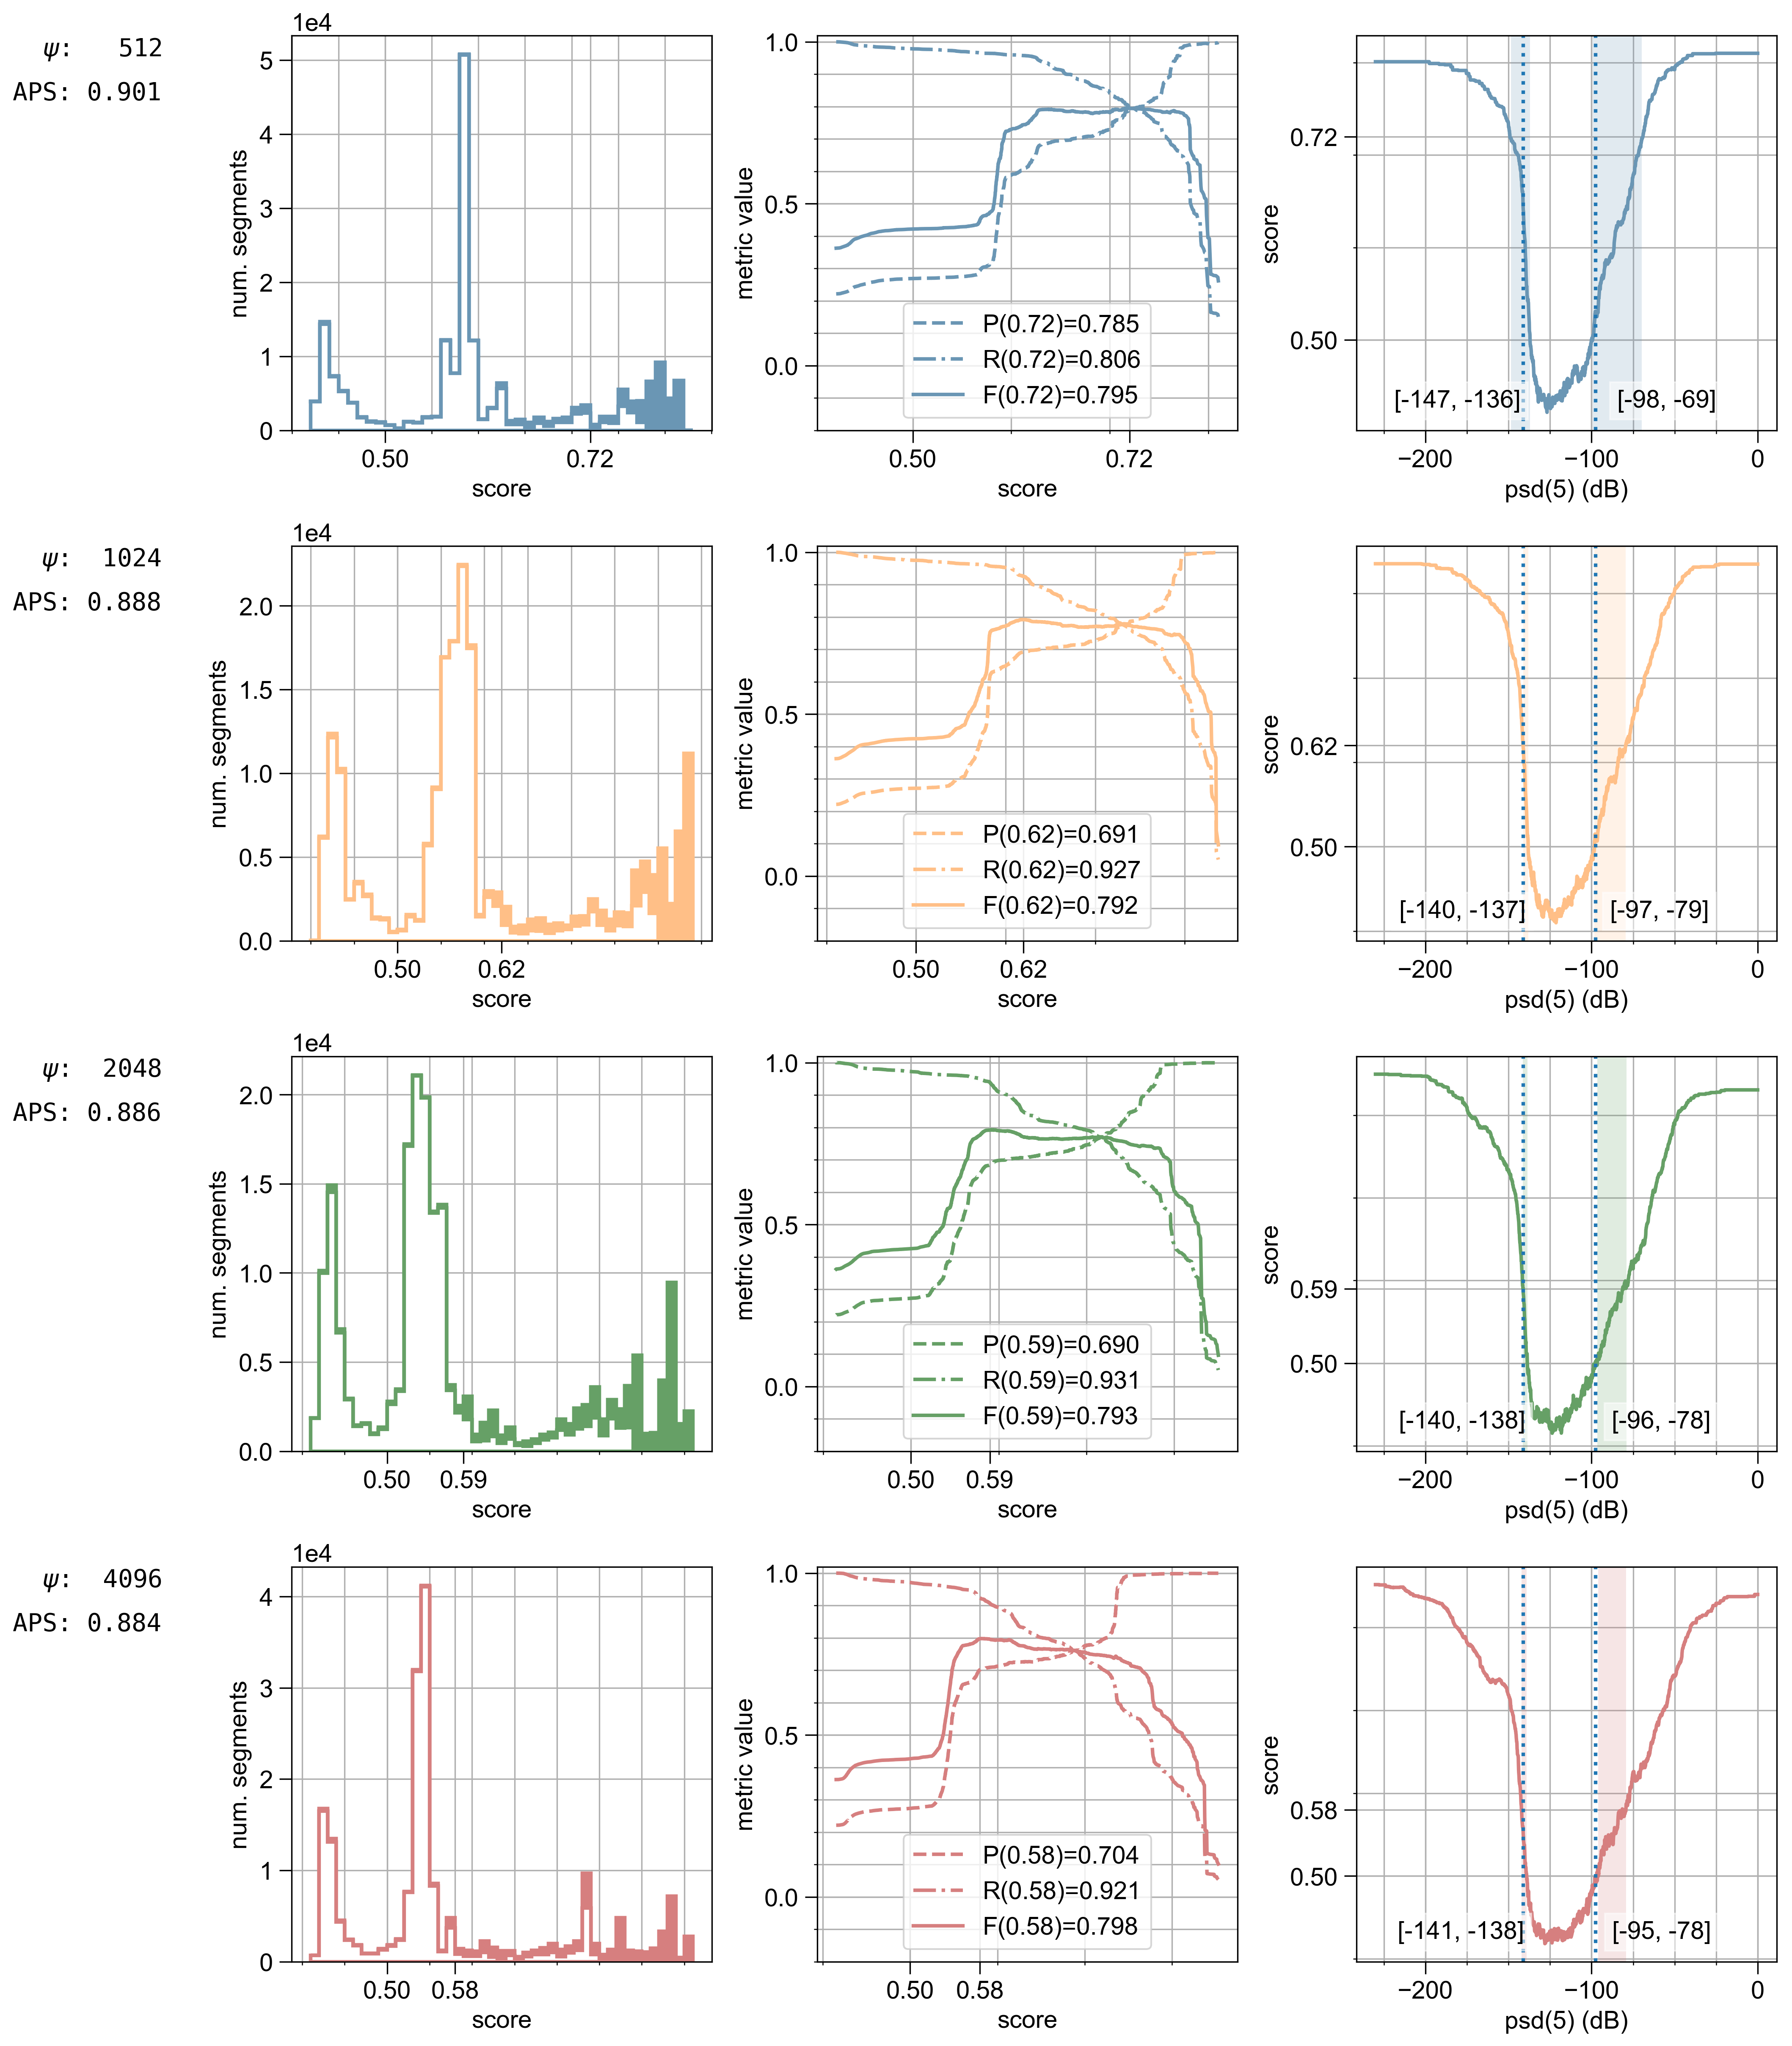

In [9]:
setname = TESTSETNAME_U

printhtml('<h3>Plotting best models in details. All metrics computed on test set "%s"</h3>' % setname)


printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
          'average precision score</h3>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])



printhtml('<h4>Defining plot function and plotting</h4>')

def plot_prediction_per_maxsamples(pred_dfs):
    
    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

    # printhtml('<h3>Summary plots n_estimators=200 only (and random_state=11)</h3>')

    PETTERSON_PERIOD = 5  # set to 0 to ignore

    rows, cols = len(pred_dfs), 4
    # rows, cols = 2*len(pred_dfs), 3
    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(rows, cols, width_ratios=[1,10, 10, 10])
    # gsp = fig.add_gridspec(rows, cols, height_ratios=[1,15] * len(pred_dfs))
    colors = get_colors(len(pd.unique([_.max_samples for _ in pred_dfs.keys()])))
    psdperiods = np.arange(-230, 0, 0.1)

    # axs_all = [[], [], []]
    for idx, (rowtuple, pred_df) in enumerate(pred_dfs.items()):
        title= "(max_s=%s)" % (rowtuple.max_samples)

        aps, p, r, th, f = EVALMETRICS.computeall(pred_df, EVALMETRICS.APS,
                                                  EVALMETRICS.PMAX, EVALMETRICS.RMAX,
                                                  EVALMETRICS.BEST_TH_PR, EVALMETRICS.F1MAX)

        axs = fig.add_subplot(gsp[idx, 1])
        mp_hist_kw = {
            'color': ['white', colors[idx]],
            'edgecolor':colors[idx],
            'histtype': 'stepfilled', 'stacked': True,
            'linewidth': 2
        }
        axs = plot_freq_distribution(pred_df, axs, title='', mp_hist_kwargs=mp_hist_kw)
        axs.set_xticks([0.5, np.round(th, 2)])
        axs.tick_params(which='major', length=7)
        axs.set_axisbelow(True)

        axs = fig.add_subplot(gsp[idx, 2])
        axs = plot_pre_rec_fscore(pred_df, axs, title='', mp_plot_kwargs={'color': colors[idx]})
        axs.tick_params(which='major', length=7)
        # bbox_to_anchor: A 2-tuple (x, y) places the corner of the legend specified by `loc` at x, y. 
        lgnd = axs.legend(loc='lower center', bbox_to_anchor=(0.5, 0))
        axs.set_ylim(-0.2, 1.02)
        axs.set_axisbelow(True)

        axs = fig.add_subplot(gsp[idx, 3])
        clf = load_clf(dirname(rowtuple.relative_filepath) + '.sklmodel')
        scores = -clf.score_samples(psdperiods.reshape(len(psdperiods), 1))
        # plot scores:
        axs.plot(psdperiods, scores, color=colors[idx], linewidth=2)
        # plot petterson:
        pbounds = get_petterson_bounds(PETTERSON_PERIOD)
        axs.axvline(pbounds[0], linestyle=':', linewidth=2)
        axs.axvline(pbounds[1], linestyle=':', linewidth=2)
        # plot shaded areas between 0.5 and score optimizing f1score:
        indices1 = argwhere_array_equals_value(scores, th)
        indices2 = argwhere_array_equals_value(scores, 0.5)
        psd_l = psdperiods[indices1[0]], psdperiods[indices2[0]]
        axs.axvspan(psd_l[0], psd_l[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
        psd_h = psdperiods[indices2[-1]], psdperiods[indices1[-1]]
        axs.axvspan(psd_h[0], psd_h[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
        axs.grid()
        # displaying bounds:
        bound1 = str([int(psd_l[0]+0.5), int(psd_l[1]+0.5)])
        bound2 = str([int(psd_h[0]+0.5), int(psd_h[1]+0.5)])
        w1 = float(psd_l[1] - psd_l[0])
        w2 = float(psd_h[1] - psd_h[0])
        axs.text(psd_l[1] - w1/2.0, min(scores), bound1, ha='right', va='bottom', backgroundcolor=[1,1,1,0.5])
        axs.text(psd_h[0] + w2/2.0, min(scores), bound2, ha='left', va='bottom', backgroundcolor=[1,1,1,0.5])
        # set axis ticks:
        axs.xaxis.set_minor_locator(MultipleLocator(25))
        axs.yaxis.set_minor_locator(MultipleLocator(0.1))
        axs.grid(axis="both", which='minor', linestyle='-')
        axs.set_yticks([0.5, np.round(th, 2)])
        axs.tick_params(which='major', length=7)
        axs.set_xlabel('psd(5) (dB)')
        axs.set_ylabel('score')
        axs.set_axisbelow(True)
        
        # summary in the leftmost plot:
        # plot it as last so we have all data avilable
        axs = fig.add_subplot(gsp[idx, 0])
        text = f'$\psi$: {rowtuple.max_samples:>5d}\nAPS: {aps:.3f}' # % (rowtuple.max_samples, aps)
        axs.text(0.5, 1, text, ha='right', va='top', rotation=0, linespacing=2, family='monospace') 
        axs.set_axis_off()

    return fig


plt.rcParams['figure.figsize'] = (14, 16)
plt.rcParams['font.size'] = 14
for nest in [100]:  # [50, 100, 200]:
    print()
    printhtml('<h4>Plotting detailed model predictions with n_estimators=%d</h4>' % nest)
    pred_dfs = get_pred_dfs(eval_df2[eval_df2.n_estimators == nest], columns=['predicted_anomaly_score', 'window_type', 'outlier', 'dataset_id'])
    for _ in list(pred_dfs):
        pred_dfs[_] = pred_dfs[_][(pred_dfs[_].dataset_id==1) & ((pred_dfs[_].window_type))]
    fig = plot_prediction_per_maxsamples(pred_dfs)
    savefig(fig, 'feat5sec_allperfs_nest=%d' % nest)
    plt.show()
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15


In [19]:
setname = TESTSETNAME_U
n_est = 100

# printhtml('<h3>Performances per dataset. All metrics computed on test set "%s"</h3>' % setname)


# printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
#           'average precision score</h3>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') & (eval_df.n_estimators == n_est) &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))

printhtml(f'Performances on "{setname}" (same as previous Notebook cell but restricted to n_estimators={n_est})"')
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

printhtml(f'Loading {len(eval_df2)} prediction dataframes to compute intra metrics')
pred_dfs = get_pred_dfs(eval_df2, columns=['predicted_anomaly_score','station_id', 'Segment.db.id', 'outlier', 'window_type', 'dataset_id', 'magnitude'])

from collections import defaultdict
metricname = 'average_precision_score'

# printhtml(f'Performances on "{setname}" (SIGNAL WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

# printhtml(f'Performances on "{setname}" (NOISE WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[~p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

for did in [1, 2, 4]:
    for wtype in (True, False):
        wtype_str = 'SIGNAL' if wtype else 'NOISE'
        printhtml(f'Performances on "{setname}" ({wtype_str} WINDOWS ONLY, DATASET_ID={did})')
        dic = defaultdict(list)
        for tupl, p in pred_dfs.items():
            _p = p[(p.dataset_id == did) & (p.window_type == wtype)]
            # print misclassified:
            N = 30
            print('Outliers missclassified (first 30 only)')
            _p = _p[~_p.station_id.isin([5831, 5833, 10179, 10186, 890])]
            
            print(" ".join(str(_) for _ in _p[(_p.outlier) & (_p.predicted_anomaly_score <0.7) ]['Segment.db.id'].head(20)))
            aps = EVALMETRICS.APS.compute(_p)
            dic[metricname] += [aps]
            for fld in tupl._fields:
                if fld != metricname:
                    dic[fld] += [getattr(tupl, fld)]
        display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

                      
# for _ in eval_df.itertuples():
#     pred_df = get_pred_df
# display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Performances on "uniform_test.hdf" (same as previous Notebook cell but restricted to n_estimators=100)"

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
1592,IsolationForest,psd@5sec,100,1024,11,0.970564,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
1604,IsolationForest,psd@5sec,100,512,11,0.970490,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1596,IsolationForest,psd@5sec,100,2048,11,0.970131,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
1602,IsolationForest,psd@5sec,100,4096,25,0.969622,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Loading 4 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=1)

11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 27247391 23048553 23072737 23383420
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361827 27247391 23048553 23072737
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361827 17365350 17365352 29454002
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 17365350


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,0.897752,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.884486,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,0.882201,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.879867,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=1)

11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 18491064
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 18491064
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 16642257
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 17365350


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,0.890704,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.873757,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,0.872331,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.871557,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=2)

16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
2,IsolationForest,psd@5sec,100,2048,11,0.987162,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.987116,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.986986,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf
0,IsolationForest,psd@5sec,100,512,11,0.982504,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf


Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=2)

16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,0.994874,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.994527,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,0.994375,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.994053,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=4)

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,1.0,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,1.0,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,1.0,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,1.0,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=4)

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,1.0,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,1.0,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,1.0,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,1.0,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


In [ ]:
printhtml('<h3>Plotting some segments and their predicted score in details</h3>')

nest = 100
maxs = 2048

# low and high ranges (in dB) of "undecided zone"
lpsd = [-152, -138]
hpsd = [-100, -66]
# ranges = [-152, -138], [-100, -66]

printhtml('<h4>Classifier used:</h4>')
eval_df3 = eval_df2[(eval_df2.n_estimators == nest) & (eval_df2.max_samples == maxs)]
display(eval_df3)
clf = load_clf(dirname(eval_df3.relative_filepath.iloc[0]) + '.sklmodel')
display(clf)
pred_df = read_pred_df(join(dirname(eval_df3.relative_filepath.iloc[0]), TESTSETNAME12), columns=None)

def ppsd_2(segment, inventory):
    periods, amplitudes_db = ppsd(seg.stream()[0], seg.inventory())
    _, amplitude_db_5 = ppsd(seg.stream()[0], seg.inventory(), 5)
    return periods, amplitudes_db, amplitude_db_5


def plot_trace(axs, trace, inventory=None, **kwargs):
    from obspy import UTCDateTime
    # time0, dt = trace.stats.starttime, trace.stats.delta
    # times = [(time0 + dt*i).datetime for i in range(len(trace))]
    # trace = trace.trim(None, trace.stats.starttime+60)
    if inventory is not None:
        trace = trace.copy().remove_response(inventory)
    axs.plot(trace, **kwargs)
    axs.set_xticks([0, len(trace)-1])
    stime = UTCDateTime(int(np.round(float(trace.stats.starttime))))
    etime = UTCDateTime(int(np.round(float(trace.stats.endtime))))
    # would be nice if the first tick displayed the date also, something as: stime.isoformat().replace('T', ' ')
    # but then labels take too much room. So:
    ticklabel1 = stime.isoformat()[stime.isoformat().find('T')+1:]
    ticklabel2 = etime.isoformat()[etime.isoformat().find('T')+1:]
    axs.set_xticklabels([ticklabel1, ticklabel2])
    axs.ticklabel_format(axis='y', style='sci', scilimits=(-0,0))
    # axs.grid()


PSD_YLIM = (-200, 75)


def plot_psd(axs, trace, inventory, **kwargs):
    periods, amplitudes_db, amplitude_db_5 = ppsd_2(trace, inventory)
    kwargs.setdefault('linewidth', 2)
    axs.semilogx(periods, amplitudes_db, **kwargs)
    
#     areacolor = [0.85, 0.85, 0.85]  # outlier zone in dark gray:
#     axs.set_facecolor(areacolor)
#     areacolor = [0.925, 0.925, 0.925]
#     axs.axhspan(lpsd[0], hpsd[1], alpha=1, zorder=-10, color=areacolor, fill=True)
#     areacolor = [1, 1, 1]
#     axs.axhspan(lpsd[1], hpsd[0], alpha=1, zorder=-10, color=areacolor, fill=True)
    
    
    axs.axvline(5, color=[0., 0., 0.], linewidth=6)
    axs.plot([5, 5], [lpsd[0], hpsd[1]], marker='None', color=[0.75, 0.75, 0.75], linewidth=6)
    axs.plot([5, 5], [lpsd[1], hpsd[0]], marker='None', color=[1, 1, 1], linewidth=6)
    
#     areacolor = [0.85, 0.85, 0.85]  # outlier zone in dark gray:
#     axs.set_facecolor(areacolor)
#     areacolor = [0.925, 0.925, 0.925]
#     axs.axhspan(lpsd[0], hpsd[1], alpha=1, zorder=-10, color=areacolor, fill=True)
#     areacolor = [1, 1, 1]
#     axs.axhspan(lpsd[1], hpsd[0], alpha=1, zorder=-10, color=areacolor, fill=True)
    
    
    # areacolor = [0.8, 0.8, 0.8]
    # axs.axhline(lpsd[1], linestyle='--', zorder=-5, color=areacolor)
    # axs.axhline(hpsd[0], linestyle='--', zorder=-5, color=areacolor)
    
    clf_score = -clf.score_samples([[amplitude_db_5]])
    color = kwargs.get('color', 'black')
    axs.scatter(5, amplitude_db_5, marker='o', label='score=%.2f' % clf_score,
                color='white', edgecolor=color, linewidth=2, zorder=100)
    axs.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', mode='expand')
    axs.set_ylim(*PSD_YLIM)
    #axs.grid()

fig = plt.figure(constrained_layout=True)
gsp = fig.add_gridspec(6, 4, width_ratios=[1, 10, 10, 10])
    
colors = get_colors(2, 0.35, 0.6)  # [::-1]

def plotall(segment, row_idx, caption, trace=None, inv=None):
    '''plots a row of plots'''
    if trace is None:
        trace = segment.stream()[0]
    if inv is None:
        inv = segment.inventory()
    # show the already computed scores for a double check:
    seg_pred_df = pred_df[(pred_df['Segment.db.id'] == seg.id) & (pred_df.dataset_id == dataset_id)]
    print()
    print('Segment to plot:')
    display(seg_pred_df)
    # get all channel segments and print median score:
    scores = pred_df[(pred_df.station_id == seg.channel.station_id) & (pred_df.dataset_id == dataset_id) &
                     (pred_df.location_code == seg.channel.location) & (pred_df.channel_code == seg.channel.channel)].predicted_anomaly_score
    print('%d segments of same channel found, median score: %.2f' % (len(scores), scores.median()))
    print()
    # assert labelling is correct (just a check):
    outliers_count = seg_pred_df.outlier.sum() 
    assert outliers_count in (0, len(seg_pred_df))
    kwargs = {'color': colors[bool(outliers_count)]}
    # plot stuff:
    axs0 = fig.add_subplot(gsp[row_idx, 0])
    axs0.text(0.5, 1, caption, ha='right', va='top', rotation=0, linespacing=2,
              fontsize=plt.rcParams['axes.titlesize'])  # , family='monospace') 
    axs0.set_axis_off()
    axs1 = fig.add_subplot(gsp[row_idx, 1])
    plot_trace(axs1, trace, **kwargs)
    axs2 = fig.add_subplot(gsp[row_idx, 2])
    plot_trace(axs2, trace, inv, **kwargs)
    axs3 = fig.add_subplot(gsp[row_idx, 3])
    plot_psd(axs3, trace, inv, **kwargs)
    # if row_idx == 0:
    #    axs1.set_title('Trace')
    #    axs2.set_title('Trace (resp. removed)')
    #    axs3.set_title('PSD')
    
    allaxes = axs1, axs2, axs3
    # don't know why, but the gird appears on the LASt psd (??!)
    # turn grid off for all axes (set to True to turn it on):
    for _ in allaxes:
        _.grid(False, which='major', axis='both', linewidth=0)
    return allaxes


plt.rcParams['figure.figsize'] = (14, 16)
plt.rcParams['font.size'] = 14


# filter for the db query (common to all):
flt = (Segment.has_data) & (Segment.maxgap_numsamples.between(-0.499, 0.499))

psd_axes = []
rowindex = -1

# good station, segment is an outlier
rowindex += 1
dataset_id = 1
sess = get_db_session(dataset_id)
try:
    # sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
    # seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = 21202165  # int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Segment artifact')
    psd_axes.append(_[-1])
finally:
    sess.close()

# Scale_units = nm/sec
# they specify a good scale_units, but obspy's documentation asserts that they
# assume units in m/sec (FIXME: citation?!!)
rowindex += 1
dataset_id = 1
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SL' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Channel big scale\n(scale_units $\\dfrac{nm}{sec})$')
    psd_axes.append(_[-1])
finally:
    sess.close()

# Scale is big,  but scale units is ok, most likely metadata error.
# We cannot say which is the cause, but the anomaly detector is good
# (we suspect some mistake in the inventory)
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SJ' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    # in this case, display only noise otherwise it seems we
    # can classify only signals:
    tra = seg.stream()[0].copy().trim(None, seg.stream()[0].stats.starttime + 60)
    _ = plotall(seg, rowindex, 'Channel big scale\n(potential\nmetadata error)', trace=tra)  
    psd_axes.append(_[-1])
finally:
    sess.close()

    
# # Metadata stage gain error
# from obspy import read_inventory
# inv = read_inventory(join(dirname(dirname(os.get_cwd())), 'stream2segment', 'inventories',
#                           'CH.GRIMS.2015-10-30T10:50:00.xml'))
# rowindex += 1
# dataset_id = 1
# sess = get_db_session(dataset_id)
# try:
#     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
#     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
#     seg_ids = seg_ids['Segment.db.id'].tolist()
#     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2016, 1, 1)) & flt).limit(1).one()
#     _ = plotall(seg, rowindex, 'Metadata\nstage gain\nerror', inv=inv)
#     psd_axes.append(_[-1])
# finally:
#     sess.close()

    
# # Metadata stage gain error
# rowindex += 1
# dataset_id = 1
# sess = get_db_session(dataset_id)
# try:
#     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
#     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
#     seg_ids = seg_ids['Segment.db.id'].tolist()
#     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2018, 1, 1)) & flt).limit(1).one()
#     _ = plotall(seg, rowindex, 'Stage gain\nerror fixed')
#     psd_axes.append(_[-1])
# finally:
#     sess.close()

    
# Broken sensor:
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_ids = seg_ids['Segment.db.id'].tolist()
    seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2019, 1, 1)) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Broken sensor')
    psd_axes.append(_[-1])
finally:
    sess.close()

# Broken sensor repaired (same channel as above):
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_ids = seg_ids['Segment.db.id'].tolist()
    seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2019, 6, 1)) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Repaired sensor')
    psd_axes.append(_[-1])
finally:
    sess.close()


# Low channel noise
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Channel low\nnoise level')
    psd_axes.append(_[-1])
finally:
    sess.close()

# for _ in psd_axes:
#    _.set_ylim(-200, 50)
# samey(psd_axes)

savefig(fig, 'interesting_segments_detailed_scores')
plt.grid()
plt.show()


plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15

Plotting some segments and their predicted score in details

Classifier used:

,clf,feats,n_estimators,max_samples,random_state,roc_auc_score,average_precision_score,log_loss,best_th_pr_curve,behaviour,best_th_roc_curve,contamination,relative_filepath,tr_set
5040,IsolationForest,psd@5sec,100,2048,11,0.974035,0.970464,0.610812,0.756818,new,0.750291,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf


IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=11, verbose=0, warm_start=False)


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,hand_labelled,outlier,predicted_anomaly_score
699493,21202165,1,4451,HNZ,,False,2016-12-06 08:46:56,True,True,0.650882
699494,21202165,1,4451,HNZ,,True,2016-12-06 08:46:56,True,True,0.851931


2154 segments of same channel found, median score: 0.64


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,hand_labelled,outlier,predicted_anomaly_score
714098,17878897,1,7744,HHE,,False,2016-10-26 21:52:52,True,True,0.716124
714099,17878897,1,7744,HHE,,True,2016-10-26 21:52:52,True,True,0.703147


1188 segments of same channel found, median score: 0.68


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,hand_labelled,outlier,predicted_anomaly_score
837566,828,2,1070,BHZ,,False,2019-08-29 15:07:59,True,True,0.851931
837567,828,2,1070,BHZ,,True,2019-08-29 15:07:59,True,True,0.851931


5968 segments of same channel found, median score: 0.85


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,hand_labelled,outlier,predicted_anomaly_score
775824,426081,2,1061,BHZ,,False,2018-08-17 04:35:27,True,True,0.833280
775825,426081,2,1061,BHZ,,True,2018-08-17 04:35:27,True,True,0.834483


3572 segments of same channel found, median score: 0.83


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,hand_labelled,outlier,predicted_anomaly_score
690929,10673,2,1061,BHZ,,False,2019-08-10 03:41:21,True,False,0.423876
690930,10673,2,1061,BHZ,,True,2019-08-10 03:41:21,True,False,0.428870


3572 segments of same channel found, median score: 0.83


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,hand_labelled,outlier,predicted_anomaly_score
646287,2058,2,1010,BHZ,,False,2019-08-28 23:46:40,True,False,0.778989
646288,2058,2,1010,BHZ,,True,2019-08-28 23:46:40,True,False,0.746974


3292 segments of same channel found, median score: 0.77



Saving figure to "~/Nextcloud/rizac/outliers_paper/paper_figures/interesting_segments_detailed_scores.png"

In [10]:
# robustness wrt gain change in the response
# create an array of 100 "good" psd periods (see figure above)
psds = np.random.uniform(lpsd[1],hpsd[0], [1000,1]) # A 2x3 array
scores = -clf.score_samples(psds)
cc = (scores <= 0.5).sum() / float(len(scores))
printhtml(f'<h4>CC instances (<=0.5): {cc:.2f}</h4>')
data = {'Resp. multiplication factor': [], 'Correctly classified ratio': []}
for factor in [0.001, 0.01, 0.1, 1, 10, 100, 150, 1000]:
    # factor = 10.0 ** N
    if factor == 1:
        cc_ = cc
    else:
        psds_ = np.copy(psds) - 10 * np.log10(factor ** 2)
        scores_ = -clf.score_samples(psds_)
        cc_ = (scores_ > 0.75).sum() / float(len(scores_))
    data['Resp. multiplication factor'].append(factor)
    data['Correctly classified ratio'].append(cc_)

display(pd.DataFrame(data))

CC instances (<=0.5): 0.95

,Resp. multiplication factor,Correctly classified ratio
0,0.001,0.759
1,0.010,0.242
2,0.100,0.000
3,1.000,0.950
4,10.000,0.167
5,100.000,0.679
6,150.000,0.774
7,1000.000,1.000
